## Telcom Company Customer Churning Analysis

### Packages Importation

In [1]:
#importing the necessary packages
import pyodbc 
from dotenv import dotenv_values
import pandas as pd
import numpy as np
import warnings 
import seaborn as sns
import matplotlib.pyplot as plt

#modelling Libraries
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,accuracy_score,precision_score,recall_score,f1_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn import metrics
from imblearn.combine import SMOTEENN
from sklearn.neighbors import KNeighborsClassifier

# Feature Processing (Scikit-learn processing, etc.)
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import classification_report
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

#Algorithms and pipeline

from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer 
from imblearn.pipeline import Pipeline
from sklearn.ensemble import BaggingClassifier

##handling imbalance datasets

from imblearn.over_sampling import SMOTE
from sklearn.utils.class_weight import compute_class_weight

warnings.filterwarnings('ignore')

KeyboardInterrupt: 

### Loading the Environment Variables from .env file into a dictionary

In [ ]:
#load environment variables from .env file into a dictionary
environment_variables = dotenv_values('.env')
#Get the values for the credentials you set in the '.env' file
database = environment_variables.get("DATABASE")
server = environment_variables.get("SERVER")
username = environment_variables.get("USERNAME")
password = environment_variables.get("PASSWORD")

connection_string = f"DRIVER={{SQL Server}}; SERVER={server};DATABASE={database};UID={username};PWD={password}"

In [ ]:
# Use the connect method of the pyodbc library and pass in the connection 
# string this will connect to the server.

connection = pyodbc.connect(connection_string)

### HYPOTHESIS
Null Hypothesis (H0): There is no significant difference in churn rate between customers with shorter tenure and customers with longer tenure.

Alternative Hypothesis (H1): Customers who have shorter tenure with the company are more likely to churn than customers with longer tenure.


### QUESTIONS

1. **What is the overall churn rate in the dataset?**
   - Calculate the percentage of customers who have churned to understand the overall churn rate.
2. **How does churn vary based on gender?**
   - Compare the churn rates between male and female customers.
3. **What is the churn rate for senior citizens vs. non-senior customers?**
   - Analyze if there is a difference in churn rates between senior and non-senior customers.
4. **What is the distribution of tenure for churned customers vs. non-churned customers?**
   - Compare the tenure distribution between customers who churned and those who did not.
5. **Are customers with higher monthly charges more likely to churn?**
   - Investigate if there is a correlation between monthly charges and churn.
6. **Do customers with specific internet service types tend to churn more?**
   - Analyze the churn rates for customers with DSL, Fiber optic, or no internet service.
7. **How does the presence of online security and online backup affect churn?**
   - Compare churn rates for customers with and without online security and backup features.
8. **Is there a relationship between tech support usage and churn?**
   - Determine if customers who use tech support more often have lower churn rates.
9. **Are customers on different contract types more or less likely to churn?**
    - Compare churn rates for customers on month-to-month contracts versus longer-term contracts.  

## DATA LOADING

In [ ]:
# Loading the data from database
churn_first_data = 'Select * from dbo.LP2_Telco_churn_first_3000'
churn_sql = pd.read_sql(churn_first_data, connection)

churn_exl= pd.read_excel('Telco-churn-second-2000.xlsx')

churn_csv= pd.read_csv('LP2_Telco-churn-last-2000.csv')

In [ ]:
# Combine all data except test data
dataframe = [churn_sql, churn_csv]
full_data = pd.concat(dataframe, ignore_index= True )

 To understand the structure of our dataset we use.info() to get:
 * The total number of rows in the DataFrame.
 * A summary of each column, including:
  * The column name.
  * The number of non-null values in that column.
  * The data type of values in that column.
 * The memory usage of the DataFrame.

In [ ]:
full_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5043 entries, 0 to 5042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        5043 non-null   object 
 1   gender            5043 non-null   object 
 2   SeniorCitizen     5043 non-null   object 
 3   Partner           5043 non-null   object 
 4   Dependents        5043 non-null   object 
 5   tenure            5043 non-null   int64  
 6   PhoneService      5043 non-null   object 
 7   MultipleLines     4774 non-null   object 
 8   InternetService   5043 non-null   object 
 9   OnlineSecurity    4392 non-null   object 
 10  OnlineBackup      4392 non-null   object 
 11  DeviceProtection  4392 non-null   object 
 12  TechSupport       4392 non-null   object 
 13  StreamingTV       4392 non-null   object 
 14  StreamingMovies   4392 non-null   object 
 15  Contract          5043 non-null   object 
 16  PaperlessBilling  5043 non-null   object 


In [ ]:
# Check if our dataset has null values
full_data.isnull().sum()

customerID            0
gender                0
SeniorCitizen         0
Partner               0
Dependents            0
tenure                0
PhoneService          0
MultipleLines       269
InternetService       0
OnlineSecurity      651
OnlineBackup        651
DeviceProtection    651
TechSupport         651
StreamingTV         651
StreamingMovies     651
Contract              0
PaperlessBilling      0
PaymentMethod         0
MonthlyCharges        0
TotalCharges          5
Churn                 1
dtype: int64

In [ ]:
# Check the descriptive statistics of numeric variables
full_data.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,False,True,False,1,False,None,DSL,False,...,False,False,False,False,Month-to-month,True,Electronic check,29.850000,29.85,False
1,5575-GNVDE,Male,False,False,False,34,True,False,DSL,True,...,True,False,False,False,One year,False,Mailed check,56.950001,1889.5,False
2,3668-QPYBK,Male,False,False,False,2,True,False,DSL,True,...,False,False,False,False,Month-to-month,True,Mailed check,53.849998,108.150002,True
3,7795-CFOCW,Male,False,False,False,45,False,None,DSL,True,...,True,True,False,False,One year,False,Bank transfer (automatic),42.299999,1840.75,False
4,9237-HQITU,Female,False,False,False,2,True,False,Fiber optic,False,...,False,False,False,False,Month-to-month,True,Electronic check,70.699997,151.649994,True


## DATA CLEANING

In [ ]:
columns_to_replace = ['Partner', 'Dependents', 'PhoneService', 'MultipleLines',
                      'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
                      'StreamingTV', 'StreamingMovies', 'PaperlessBilling', 'Churn']

for col in columns_to_replace:
    full_data[col] = full_data[col].replace({True: 'Yes', False: 'No'})

In [ ]:
full_data['SeniorCitizen'] = full_data['SeniorCitizen'].replace({0: 'No', 1: 'Yes'})

We shall create an assumption that fills nan values with 'No phone service' and 'No internet service'. This will apply to the following columns:'MultipleLines', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies'

In [ ]:
full_data['MultipleLines'] = full_data['MultipleLines'].fillna('No phone service')

# Define a dictionary with replacement values for each column 
replacement_dict = {
    'OnlineSecurity': 'No internet service', 
    'OnlineBackup':'No internet service' , 
    'DeviceProtection': 'No internet service',
    'TechSupport' : 'No internet service',
    'StreamingTV' : 'No internet service',
    'StreamingMovies' : 'No internet service',
} 

# Replace NaN values in the DataFrame with the specified words based on the dictionary 
full_data= full_data.fillna(replacement_dict)

In [ ]:
# Check if our dataset has null values after NULL Replacement
full_data.isnull().sum()

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        5
Churn               1
dtype: int64

### Handling Total Charges Missing Values 

In [ ]:
# Convert the object column to float, preserving missing values as NaN
full_data['TotalCharges'] = pd.to_numeric(full_data['TotalCharges'], errors='coerce')

# Round the values to 2 decimal places
full_data['TotalCharges'] = full_data['TotalCharges'].round(2)

In [ ]:
full_data['TotalCharges'].describe()

count    5035.000000
mean     2302.062860
std      2269.483575
min        18.800000
25%       417.675000
50%      1401.150000
75%      3862.000000
max      8670.100000
Name: TotalCharges, dtype: float64

Imputing with the median is a common approach when dealing with skewed distributions or data containing outliers. The median is less sensitive to extreme values compared to the mean, making it a robust measure of central tendency. Imputing missing values with the median helps preserve the overall distribution's central tendency while minimizing the impact of outliers.

In [ ]:
# Impute missing values with the median
median_TotalCharges=full_data['TotalCharges'].median()
full_data['TotalCharges'].fillna(median_TotalCharges, inplace=True)

#### Handling churn missing values

In [ ]:
#check the row with missing column in 'Churn'
column_name = 'Churn'
# Filter rows with missing values in the specified column
rows_with_missing_in_column = full_data[full_data[column_name].isnull()]
print(rows_with_missing_in_column)

      customerID gender SeniorCitizen Partner Dependents  tenure PhoneService  \
2988  6295-OSINB   Male            No     Yes         No      72          Yes   

     MultipleLines InternetService OnlineSecurity  ... DeviceProtection  \
2988           Yes     Fiber optic            Yes  ...              Yes   

     TechSupport StreamingTV StreamingMovies  Contract PaperlessBilling  \
2988          No         Yes             Yes  Two year              Yes   

         PaymentMethod MonthlyCharges  TotalCharges  Churn  
2988  Electronic check     109.650002       7880.25   None  

[1 rows x 21 columns]


This DataFrame contains only the rows from the original 'full_data' DataFrame where the churn column has missing values. This data represents a customer's information across various services, billing, and contract details.

In [ ]:
#drop missing value in 'Churn' column
full_data = full_data.dropna(subset=['Churn'])
full_data.isnull().sum()

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

In [ ]:
full_data.head(5)

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,No,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.850000,29.85,No
1,5575-GNVDE,Male,No,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.950001,1889.50,No
2,3668-QPYBK,Male,No,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.849998,108.15,Yes
3,7795-CFOCW,Male,No,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.299999,1840.75,No
4,9237-HQITU,Female,No,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.699997,151.65,Yes


In [ ]:
full_data.describe()

,tenure,MonthlyCharges,TotalCharges
count,5042.000000,5042.000000,5042.000000
mean,32.568822,65.081376,2299.527063
std,24.525954,30.064564,2266.828751
min,0.000000,18.400000,18.800000
25%,9.000000,35.762500,417.875000
50%,29.000000,70.550003,1401.150000
75%,56.000000,90.050002,3857.012500
max,72.000000,118.650002,8670.100000


 We used .describe() calculate various statistical measures for the numerical columns in the DataFrame. Which are tenure column,	MonthlyCharges column,and TotalCharges column. We can see that in:
 
 #### Count:

All three columns ("tenure," "MonthlyCharges," and "TotalCharges") have the same count of 5042. This suggests that there are no missing values in these columns.

#### Mean (Average):

* "tenure": The average tenure (duration of service) is approximately 32.57 months. This gives an idea of the typical length of time customers have been using the service.
* "MonthlyCharges": The average monthly charge is around $65.08 This provides insight into the average cost customers are paying each month for the service.

* "TotalCharges": The average total charges amount to about $2299.53. This is the accumulated amount customers have paid over their tenure.

#### Standard Deviation:

* "tenure": The relatively high standard deviation of approximately 24.53 for tenure indicates a wide range of variability in how long customers have been with the service.
* "MonthlyCharges": The standard deviation of around 30.06 for monthly charges suggests that there is some variability in the pricing plans chosen by customers.
* "TotalCharges": With a standard deviation of about 2266.83 for total charges, there is significant variability in the amount customers have paid overall.

#### Minimum and Maximum:

* "tenure": The minimum tenure is 0, indicating that there might be instances where customers have just started or haven't stayed long. The maximum is 72, indicating long-standing customers.
* "MonthlyCharges": The range of monthly charges extends from a minimum  of $18.4 to a maximum of  $118.65.
* "TotalCharges": Total charges vary between  $18.8  and  $8670.1.

#### Percentiles:

Percentiles provide insight into the data distribution.
Median ("50%"): For "tenure," the median is 29 months, meaning half of the customers have tenures shorter than this, and half have tenures longer.
For "MonthlyCharges," the median is $70.55, indicating the middle point of the charge distribution.
For "TotalCharges," the median is  $1401.15, indicating the middle point of the accumulated charges.

In [ ]:
#drop column customerID and tenure that we don't need
full_data.drop(columns= ['customerID'], axis=1, inplace=True)
full_data.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Female,No,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.850000,29.85,No
1,Male,No,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.950001,1889.50,No
2,Male,No,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.849998,108.15,Yes
3,Male,No,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.299999,1840.75,No
4,Female,No,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.699997,151.65,Yes


In [ ]:
telco_data = full_data.copy()

##### Divide customers into bins based on tenure e.g. for tenure < 12 months: assign a tenure group if 1-12, for tenure between 1 to 2 Yrs, tenure group of 13-24; so on...

In [ ]:
# Get the max tenure
print(full_data['tenure'].max())

# Get the min tenure
print(full_data['tenure'].min())

72
0


In [ ]:
# Group the tenure in bins of 12 months
labels = ["{0} - {1}".format(i, i + 11) for i in range(0, 73, 12)]
bins = [i for i in range(0, 85, 12)]

full_data['tenure_group'] = pd.cut(full_data.tenure, bins=bins, labels=labels, right=False)

In [ ]:
full_data['tenure_group'].value_counts()

tenure_group
0 - 11     1453
60 - 71     821
12 - 23     762
24 - 35     628
48 - 59     579
36 - 47     543
72 - 83     256
Name: count, dtype: int64

In [ ]:
full_data.drop(columns= ['tenure'], axis=1, inplace=True)

In [ ]:
full_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5042 entries, 0 to 5042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   gender            5042 non-null   object  
 1   SeniorCitizen     5042 non-null   object  
 2   Partner           5042 non-null   object  
 3   Dependents        5042 non-null   object  
 4   PhoneService      5042 non-null   object  
 5   MultipleLines     5042 non-null   object  
 6   InternetService   5042 non-null   object  
 7   OnlineSecurity    5042 non-null   object  
 8   OnlineBackup      5042 non-null   object  
 9   DeviceProtection  5042 non-null   object  
 10  TechSupport       5042 non-null   object  
 11  StreamingTV       5042 non-null   object  
 12  StreamingMovies   5042 non-null   object  
 13  Contract          5042 non-null   object  
 14  PaperlessBilling  5042 non-null   object  
 15  PaymentMethod     5042 non-null   object  
 16  MonthlyCharges    5042 non-nu

#### Remove columns not required for processing

In [ ]:
100*full_data['Churn'].value_counts()/len(full_data['Churn'])

Churn
No     73.502578
Yes    26.497422
Name: count, dtype: float64

In [ ]:
full_data['Churn'].value_counts()

Churn
No     3706
Yes    1336
Name: count, dtype: int64

Data is highly imbalanced, ratio = 73:26

## DATA EXPLORATION - EDA

### UNIVARIATE ANALYSIS

1. Plot distribution of individual predictors by churn

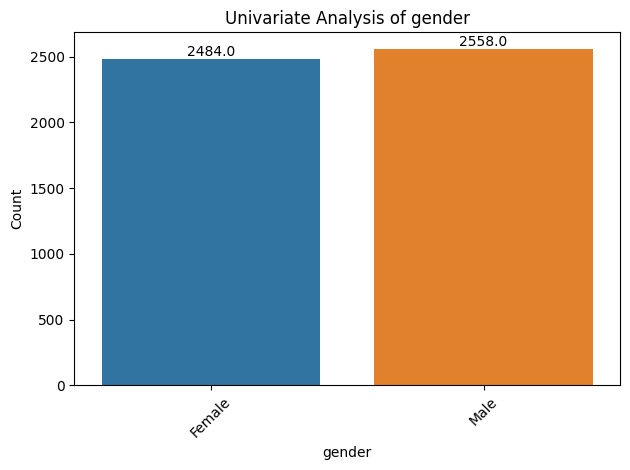

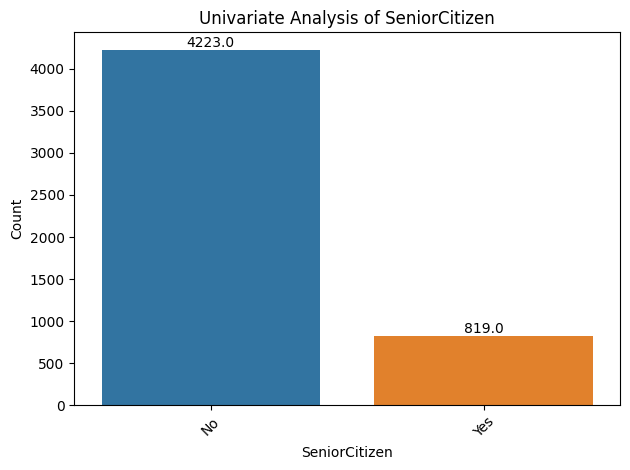

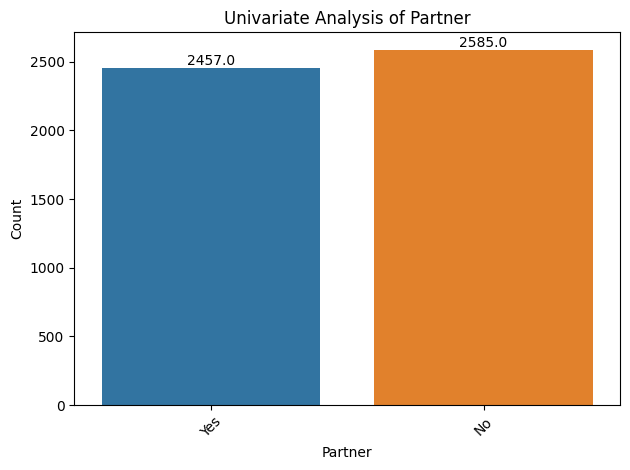

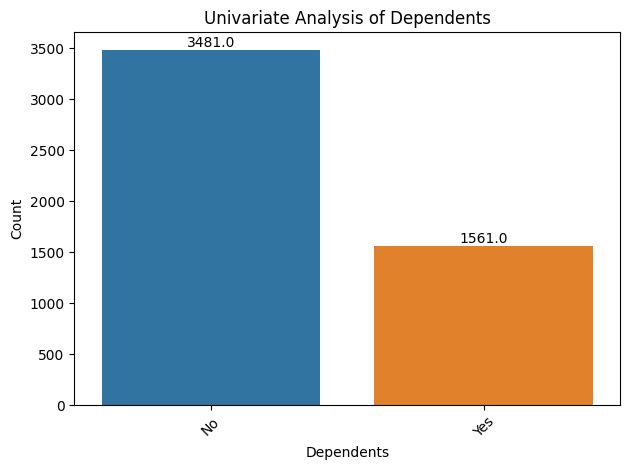

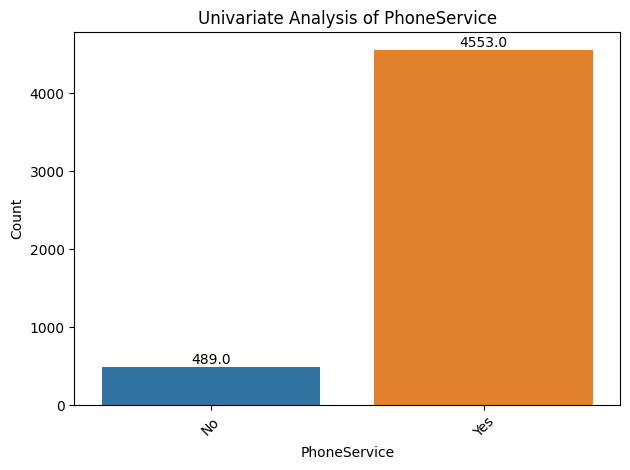

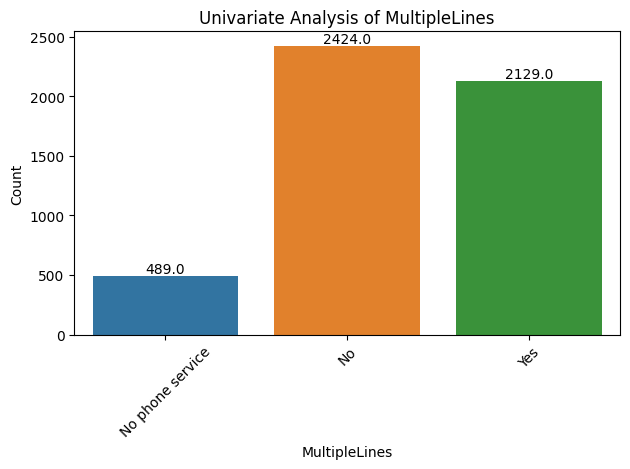

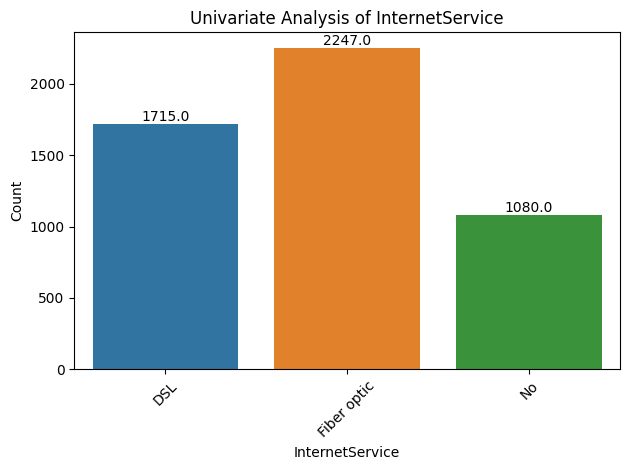

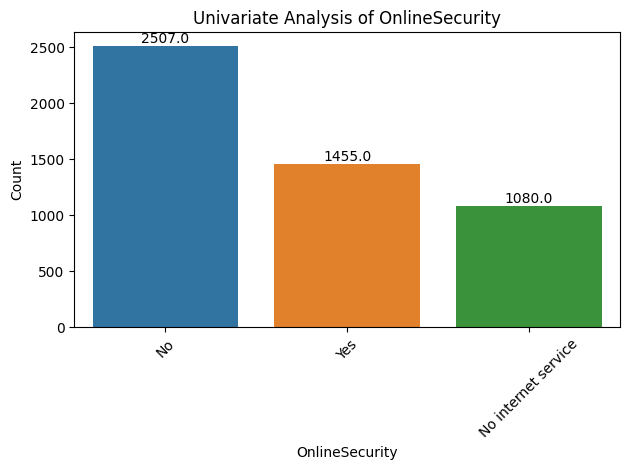

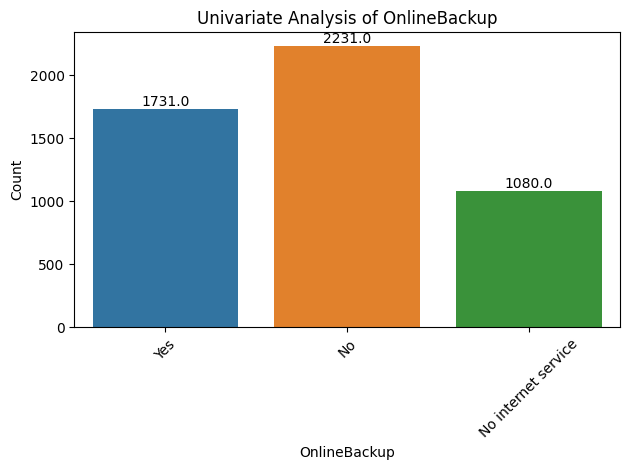

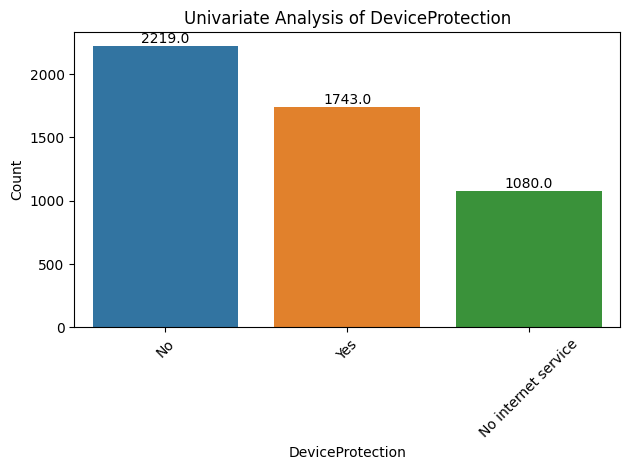

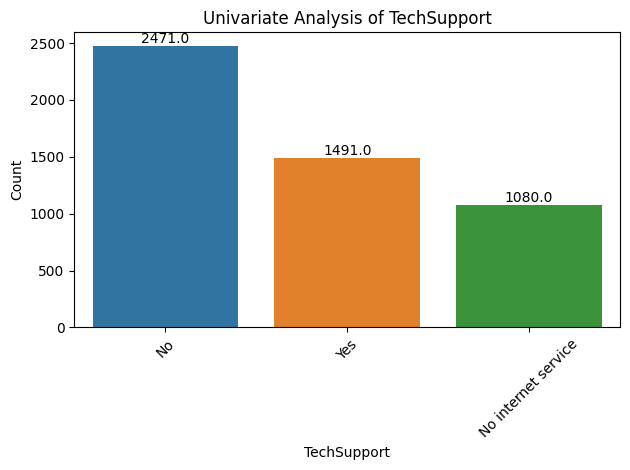

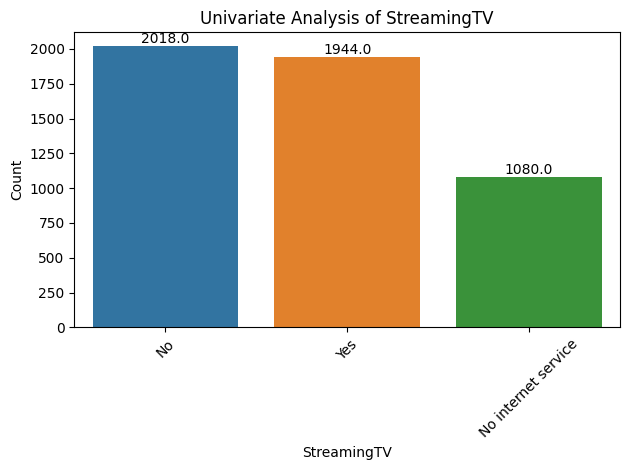

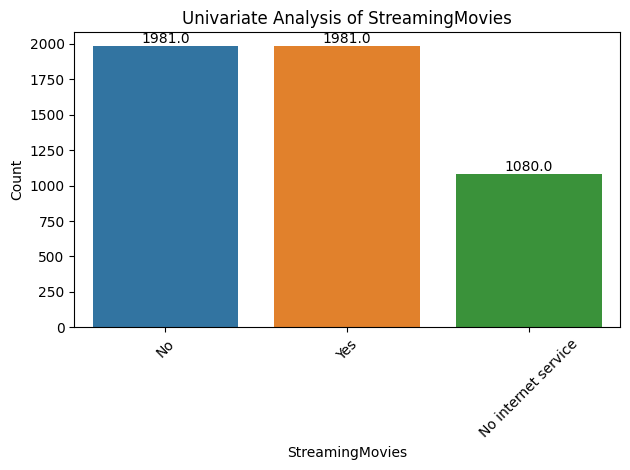

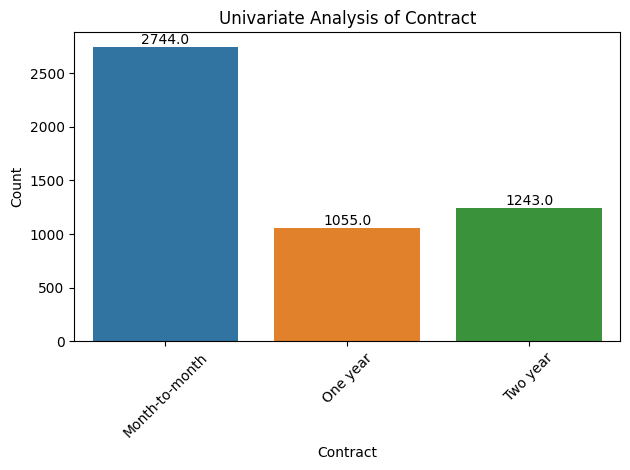

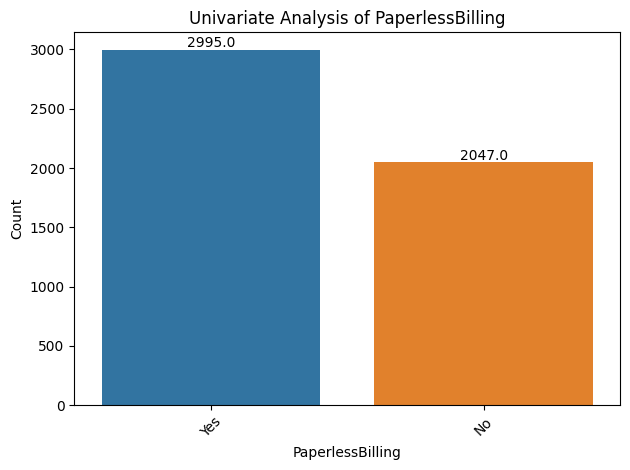

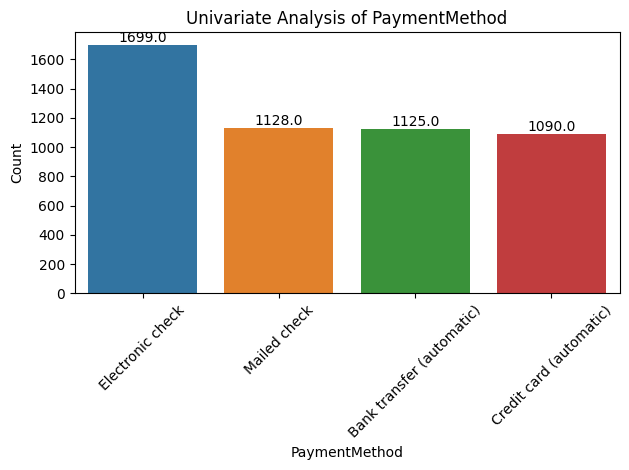

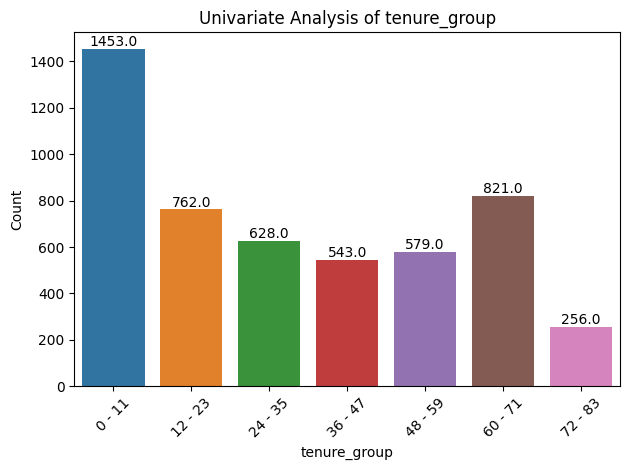

In [ ]:
# Iterate over each column (except 'Churn', 'TotalCharges', and 'MonthlyCharges')
for column in full_data.drop(columns=['Churn', 'TotalCharges', 'MonthlyCharges']):
    plt.figure()
    ax = sns.countplot(data=full_data, x=column)
    
    # Add labels to the bars
    for p in ax.patches:
        ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='center', fontsize=10, color='black', xytext=(0, 5),
                    textcoords='offset points')
    
    plt.title(f"Univariate Analysis of {column}")
    plt.xlabel(column)
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

### BIVARIATE ANALYSIS

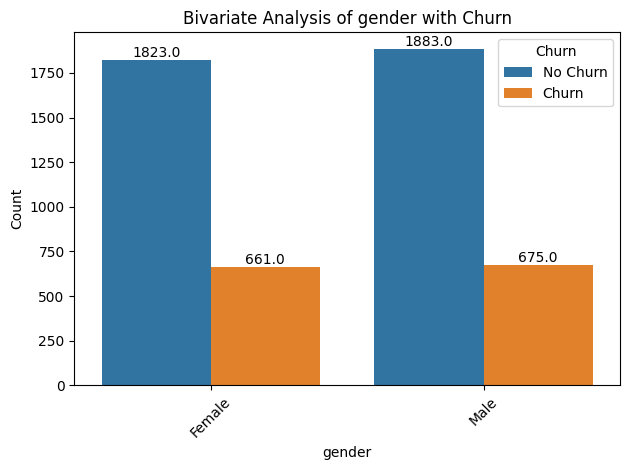

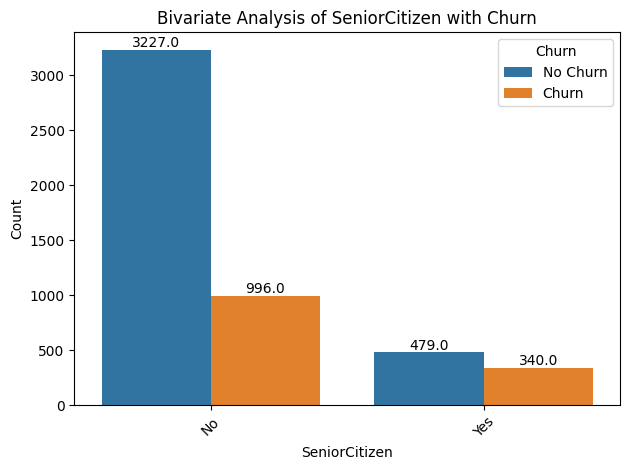

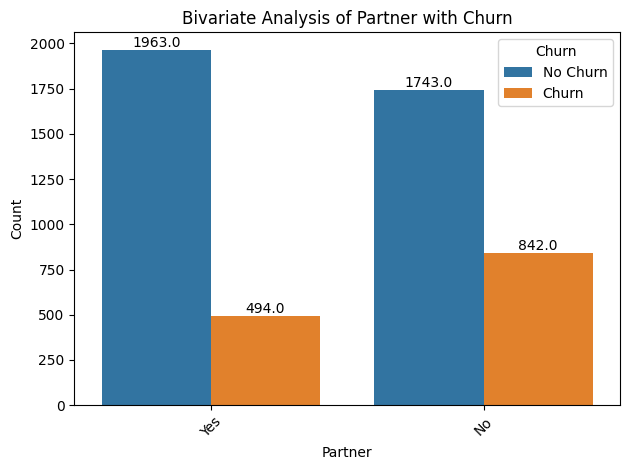

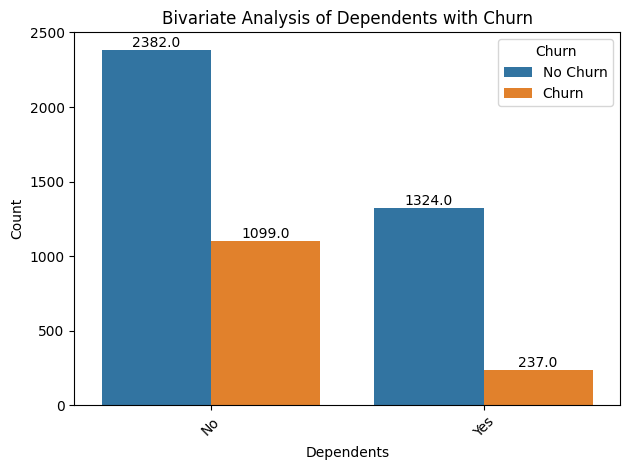

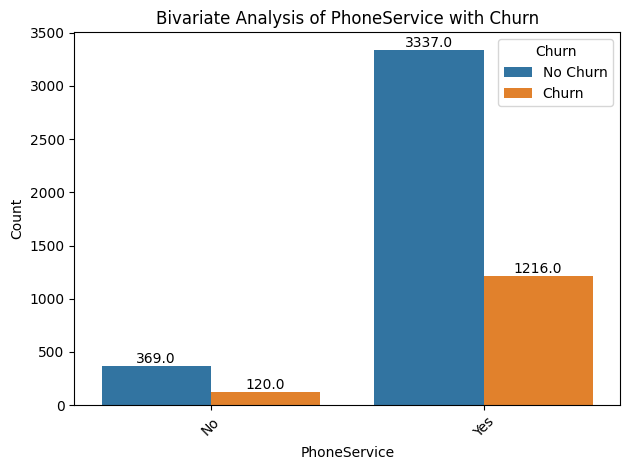

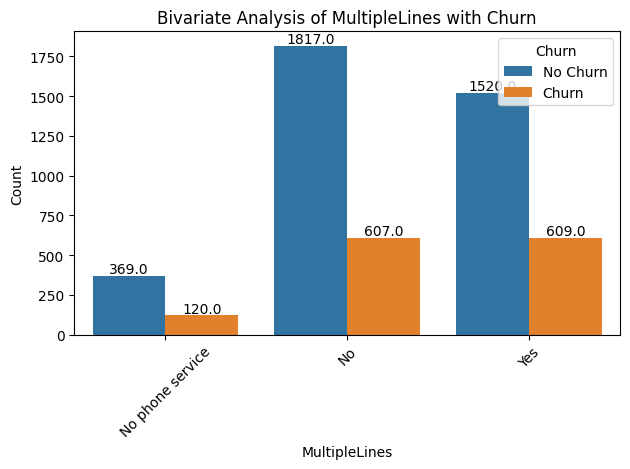

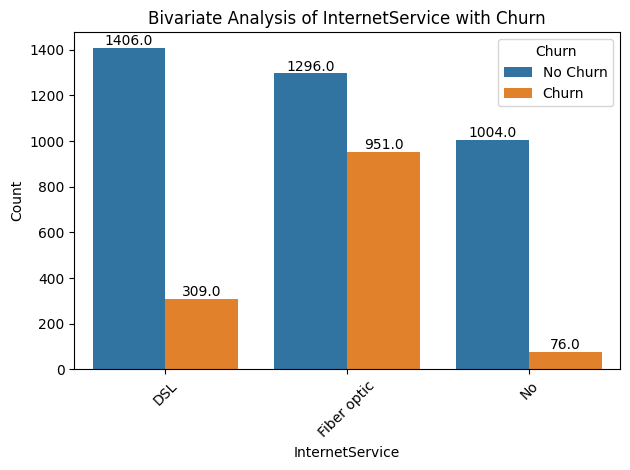

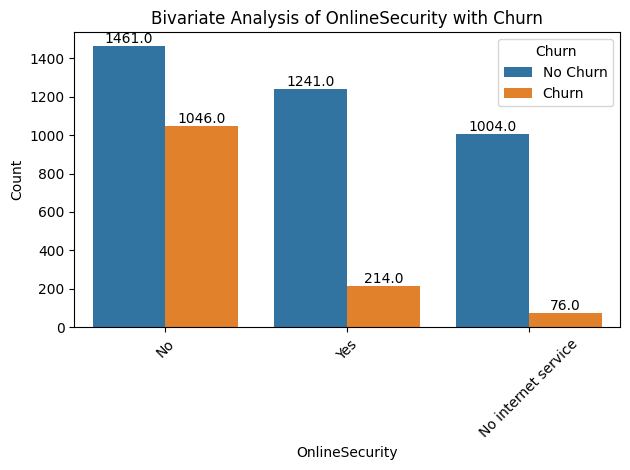

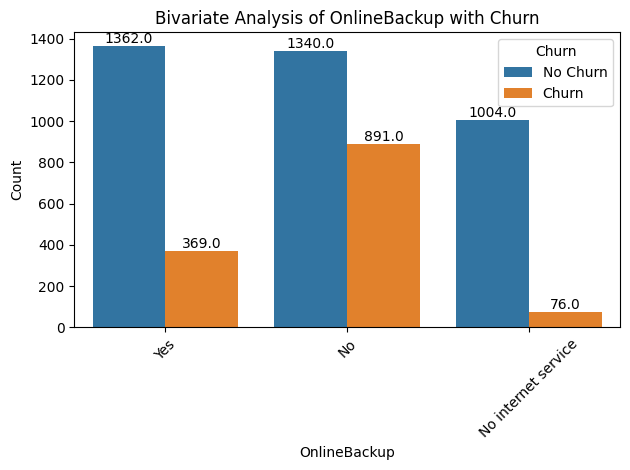

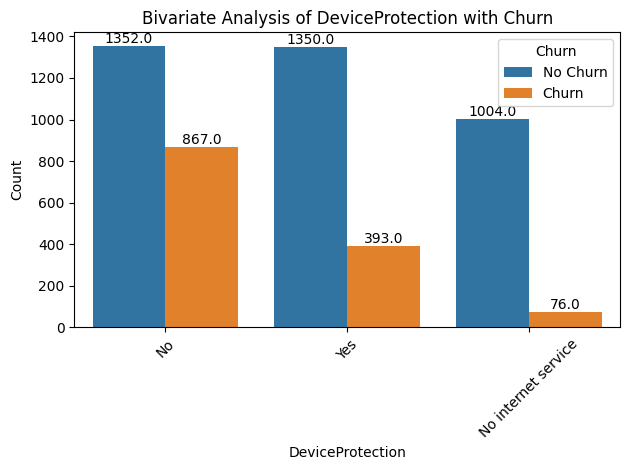

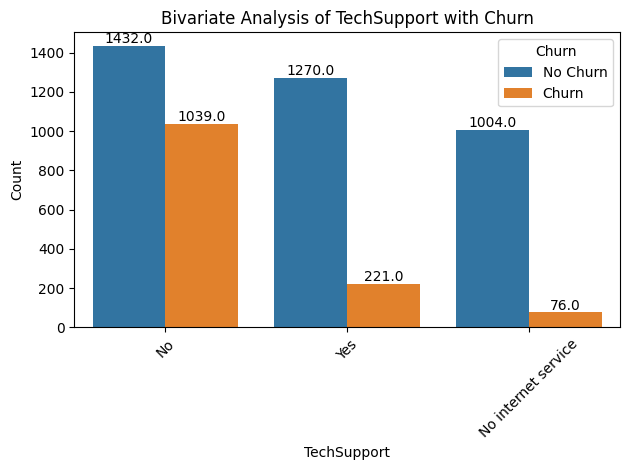

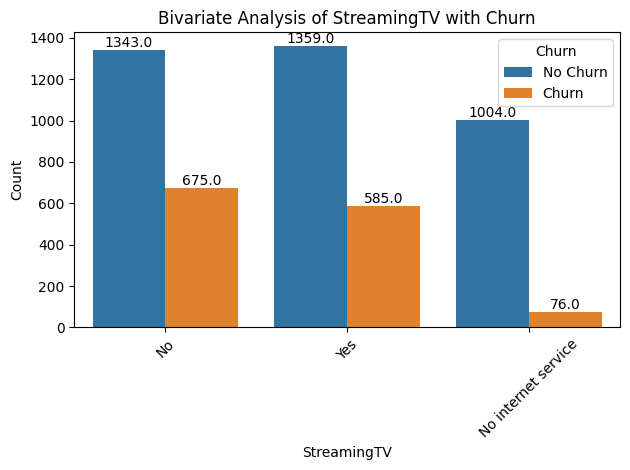

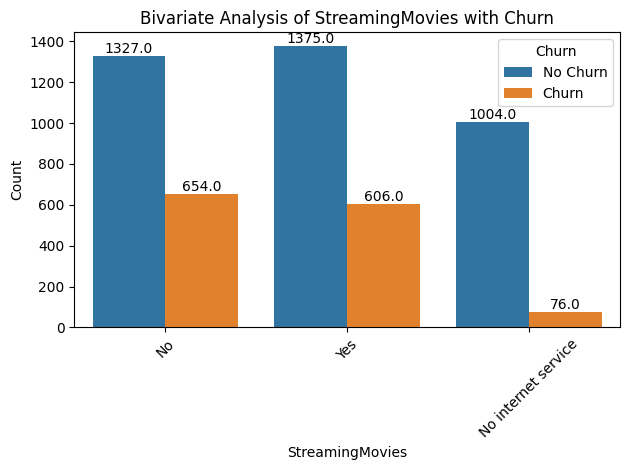

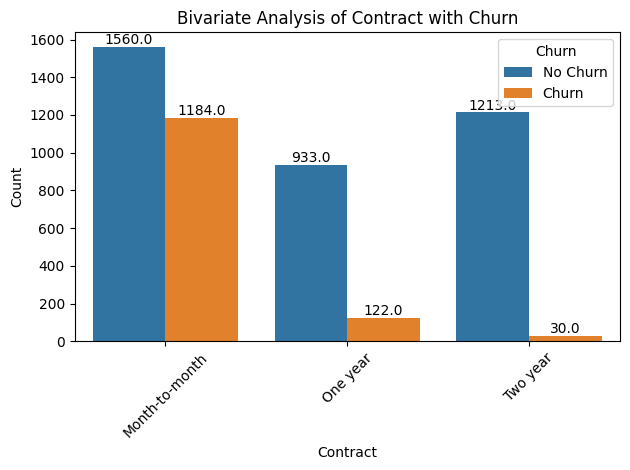

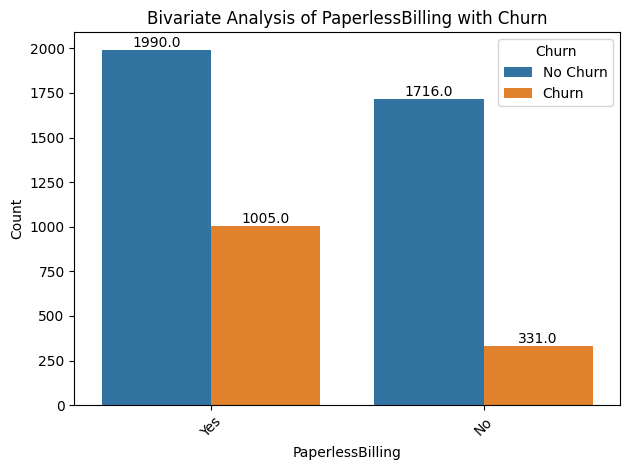

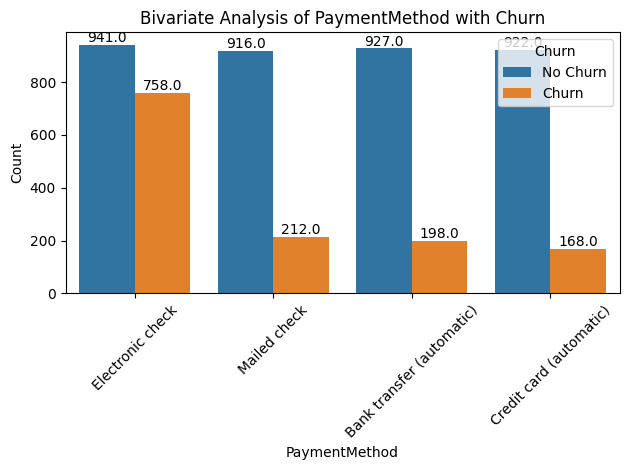

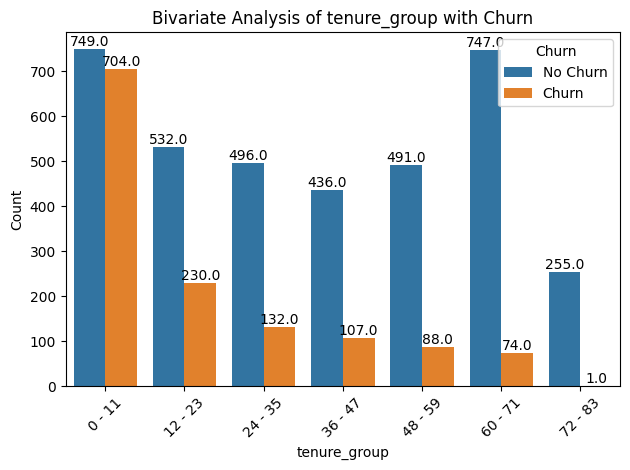

In [ ]:
# Iterate over each column (except 'Churn', 'TotalCharges', and 'MonthlyCharges')
for column in full_data.drop(columns=['Churn', 'TotalCharges', 'MonthlyCharges']):
    plt.figure()
    ax = sns.countplot(data=full_data, x=column, hue='Churn')
    
    # Add labels to the bars for 'No Churn'
    for p in ax.patches[:len(ax.patches) // 2]:
        ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='center', fontsize=10, color='black', xytext=(0, 5),
                    textcoords='offset points')
    
    # Add labels to the bars for 'Churn'
    for p in ax.patches[len(ax.patches) // 2:]:
        ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='center', fontsize=10, color='black', xytext=(0, 5),
                    textcoords='offset points')
    
    plt.title(f"Bivariate Analysis of {column} with Churn")
    plt.xlabel(column)
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.legend(title='Churn', loc='upper right', labels=['No Churn', 'Churn'])
    plt.tight_layout()
    plt.show()


## CONCLUSION
These are some of the quick insights from this exercise:

1. Electronic check medium are the highest churners
2. Contract Type - Monthly customers are more likely to churn because of no contract terms, as they are free to go customers.
3. No Online security, No Tech Support category are high churners
4. Non senior Citizens are high churners

## MULTIVARIATE ANALYSIS

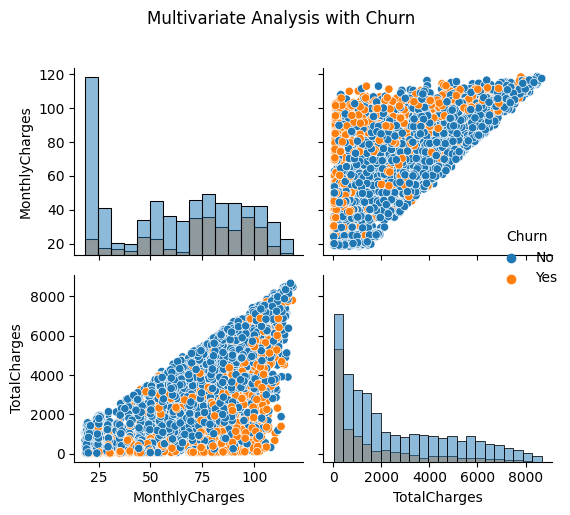

In [ ]:
# Create a pair plot with hue='Churn'
pair_plot = sns.pairplot(data=full_data, hue='Churn', diag_kind='hist')

# Add labels to the scatterplots
for ax in pair_plot.axes.flat:
    if ax is pair_plot.axes[0]:
        continue
    for p in ax.patches:
        ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='center', fontsize=8, color='black', xytext=(0, 5),
                    textcoords='offset points')

plt.suptitle("Multivariate Analysis with Churn", y=1.02)
plt.tight_layout()
plt.show()


Tenure_group, Contract Type and Churn Type

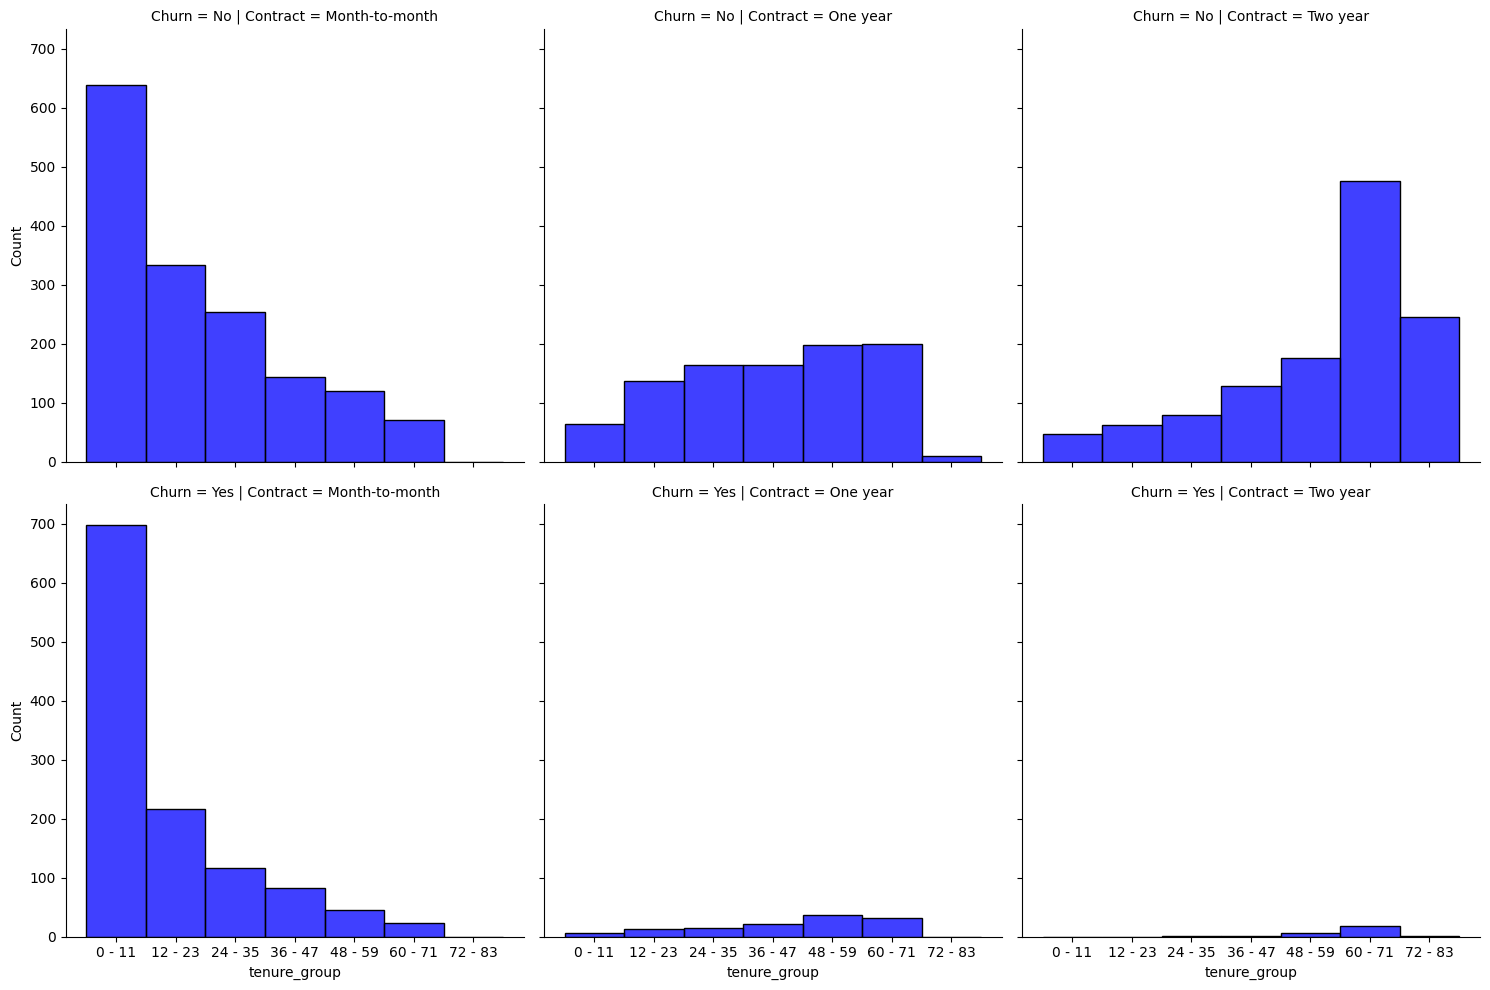

In [ ]:
#Exploring the distribution of tenure with contract type and churn type
sns.displot(data=full_data,x='tenure_group',bins=70,col="Contract",row='Churn',color='blue')

Corelation Analysis

In [ ]:
#Churned customer correlation with other categorical variables
corr_fulldata=pd.get_dummies(full_data[['gender', 'SeniorCitizen','Partner', 'Dependents','PhoneService', 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport','StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling',
       'PaymentMethod','Churn']]).corr()
full_data2 = corr_fulldata['Churn_Yes'].sort_values().iloc[1:-1]
full_data2.values

array([-0.3121582 , -0.23022526, -0.23022526, -0.23022526, -0.23022526,
       -0.23022526, -0.23022526, -0.23022526, -0.19346353, -0.17406438,
       -0.17169   , -0.17142456, -0.17014091, -0.14984785, -0.14119812,
       -0.13795733, -0.13190791, -0.10804646, -0.09370361, -0.08487265,
       -0.0650596 , -0.03174971, -0.01453664, -0.01453664, -0.00252061,
        0.00252061,  0.01453664,  0.04082666,  0.06453181,  0.07461382,
        0.11878248,  0.12867598,  0.14119812,  0.14984785,  0.17169   ,
        0.19346353,  0.25261061,  0.27130633,  0.2926598 ,  0.32152874,
        0.3430946 ,  0.34543943,  0.41229799])

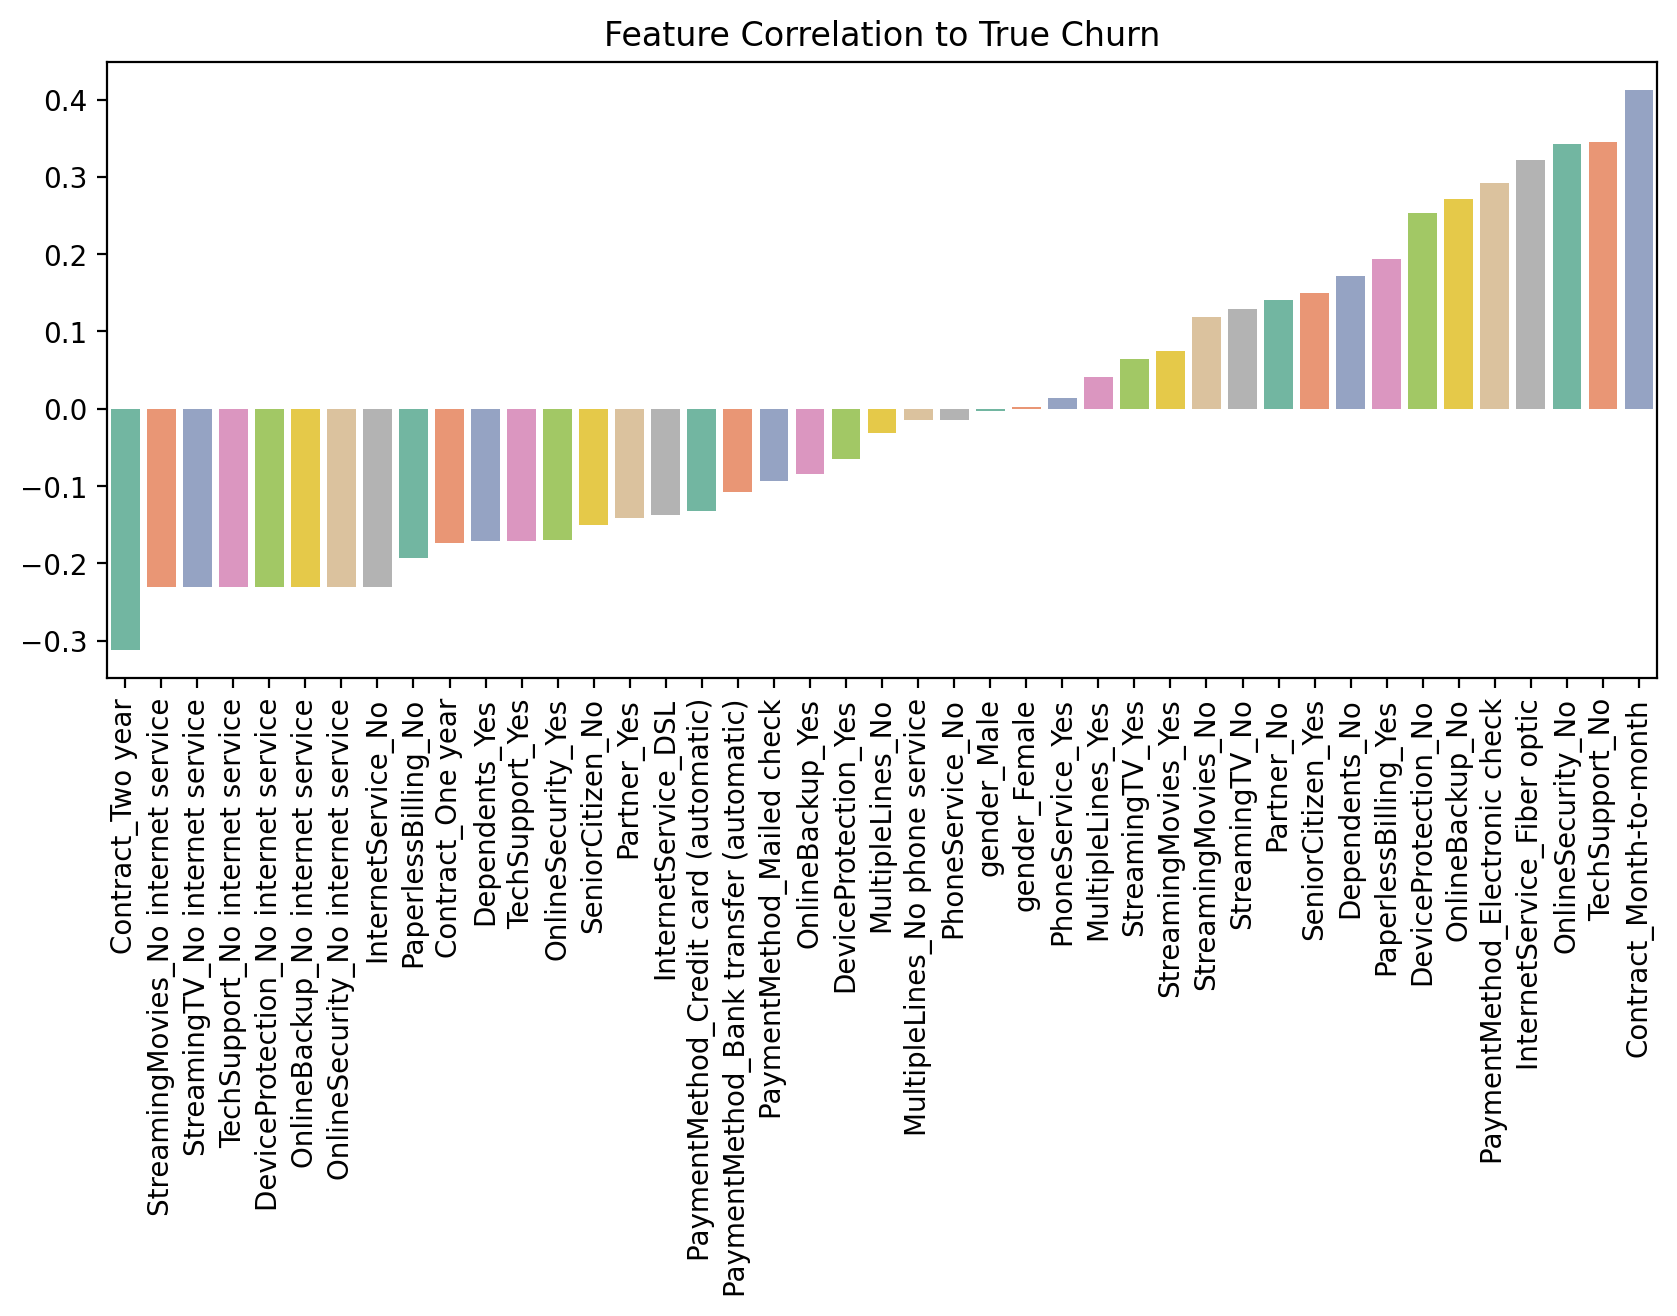

In [ ]:
plt.figure(figsize=(10,4),dpi=200)
sns.barplot(x=full_data2.index,y=full_data2.values,palette='Set2')
plt.title("Feature Correlation to True Churn")
plt.xticks(rotation=90);

Negative Correlations (Likely to Decrease Churn):

Variables with negative correlation coefficients (ranging from approximately -0.31 to -0.13) suggest that higher values in these variables are associated with a lower likelihood of customer churn. These variables might have a mitigating effect on churn. Factors related to these variables seem to encourage customer retention.

Positive Correlations (Likely to Increase Churn):

Variables with positive correlation coefficients (ranging from approximately 0.12 to 0.41) suggest that higher values in these variables are associated with a higher likelihood of customer churn. These variables might contribute to an increased risk of churn. Factors related to these variables seem to encourage customer attrition.

# QUESTIONS

1. **What is the overall churn rate in the dataset?**

In [ ]:
total_data = len(full_data)
churned_data = len(full_data[full_data['Churn'] == 'Yes'])
churn_rate = (churned_data / total_data) * 100

print(f"Overall churn rate: {churn_rate:.2f}%")

Overall churn rate: 26.50%


The churn rate is not good it should be lower.

2. **How does churn vary based on gender?**

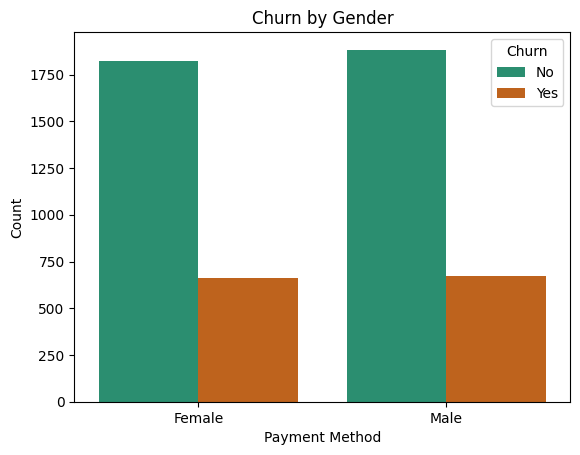

In [ ]:
sns.countplot(x='gender', hue='Churn', data=full_data, palette='Dark2')
plt.title('Churn by Gender')
plt.xlabel('Payment Method')
plt.ylabel('Count')
plt.show()

Both female and male customer tend to churn in the same rate but male tend not to churn more that the female

3. **What is the churn rate for senior citizens vs. non-senior customers?**

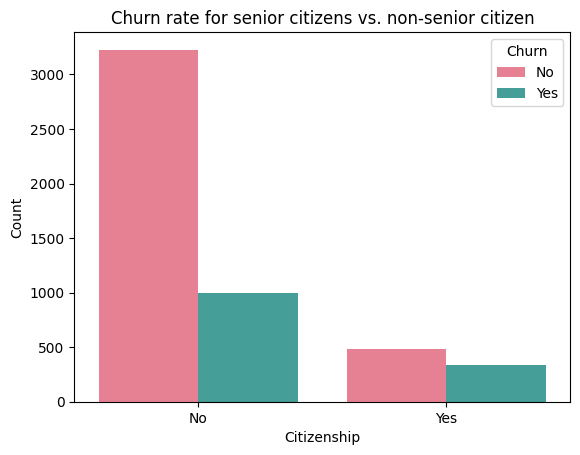

In [ ]:
# Analyze senior citizen by churn
sns.countplot(x='SeniorCitizen', hue='Churn', data=full_data, palette='husl')
plt.title('Churn rate for senior citizens vs. non-senior citizen')
plt.xlabel('Citizenship')
plt.ylabel('Count')
plt.show()

Customers that are senior citizen tend to churn high compared to those that are not non senior citizens

4. **What is the distribution of tenure for churned customers vs. non-churned customers?**

<Axes: xlabel='tenure_group', ylabel='Count'>

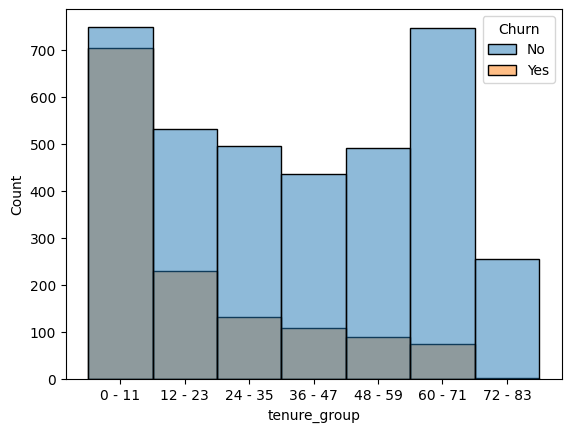

In [ ]:
#Distribution of tenure (i.e how many months customer had been with the company)
sns.histplot(data=full_data,x='tenure_group',hue = 'Churn',bins=60)

Customers which have a shorter tenure tend to churn more compared to those with a higher tenure

5. **Are customers with higher monthly charges more likely to churn?**

<Axes: xlabel='MonthlyCharges', ylabel='Count'>

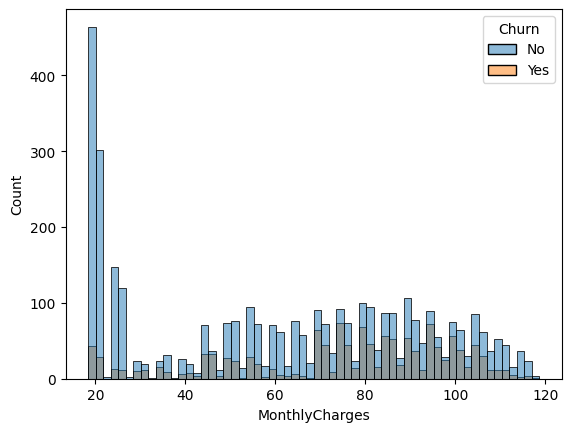

In [ ]:
#Distribution of tenure (i.e how many months customer had been with the company)
sns.histplot(data=full_data,x='MonthlyCharges',hue = 'Churn',bins=60)

Customers with monthly charges greater than 70 and but less than 100 have a higher churn rate than those with other charges

6. **Do customers with specific internet service types tend to churn more?**

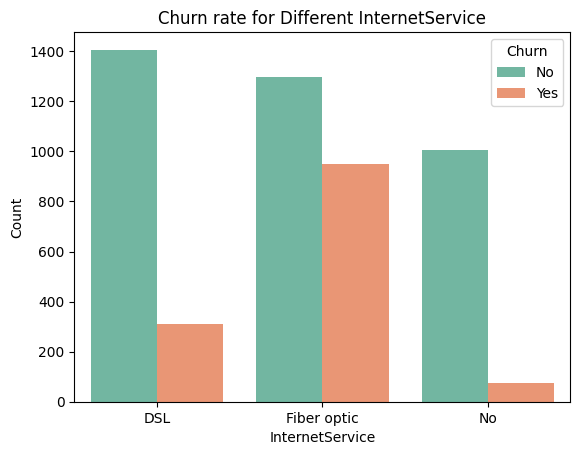

In [ ]:
sns.countplot(x='InternetService', hue='Churn', data=full_data, palette='Set2')
plt.title('Churn rate for Different InternetService')
plt.xlabel('InternetService')
plt.ylabel('Count')
plt.show()

Customers with fiber optic internet service were more likely to churn compared to those with dsl or not internet service at all 

7. **How does the presence of online security and online backup affect churn?**

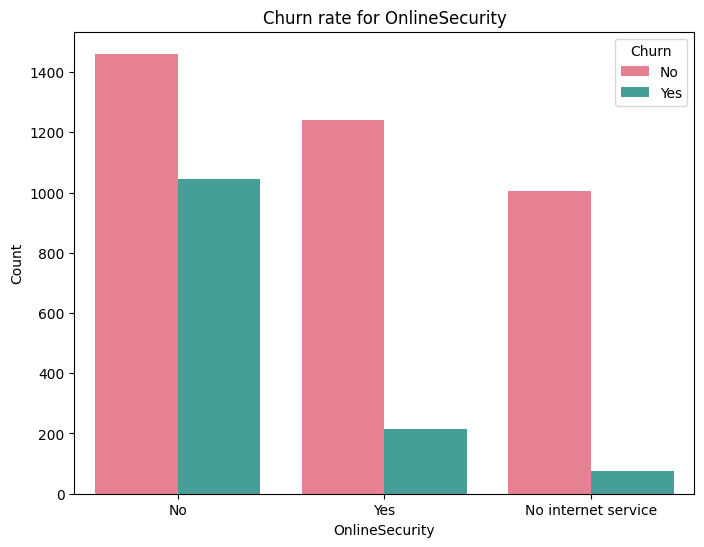

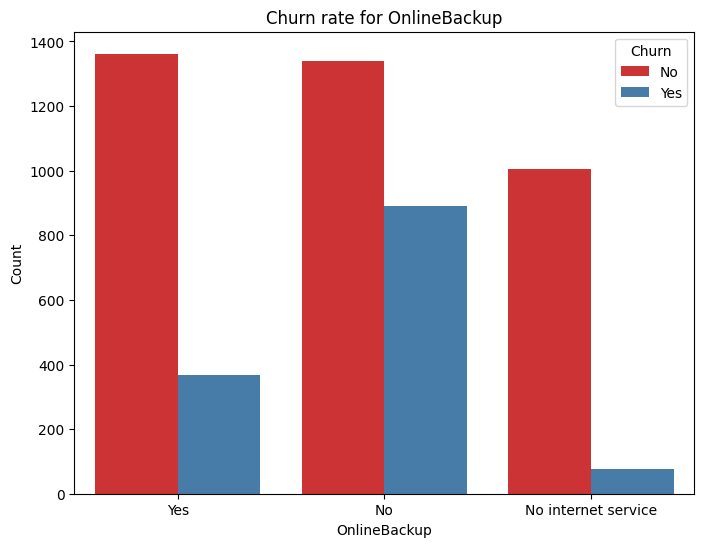

In [ ]:
# First count plot for OnlineSecurity
plt.figure(figsize=(8, 6))
sns.countplot(x='OnlineSecurity', hue='Churn', data=full_data, palette='husl')
plt.title('Churn rate for OnlineSecurity')
plt.xlabel('OnlineSecurity')
plt.ylabel('Count')
plt.show()

# Second count plot for OnlineBackup
plt.figure(figsize=(8, 6))
sns.countplot(x='OnlineBackup', hue='Churn', data=full_data, palette='Set1')
plt.title('Churn rate for OnlineBackup')
plt.xlabel('OnlineBackup')
plt.ylabel('Count')
plt.show()

Customers that didn't have online backup had a higher churn rate as compared to those that had online back up. Customers that didn't have online security had a higher churn rate as compared to those that had online security.

8. **Is there a relationship between tech support usage and churn?**

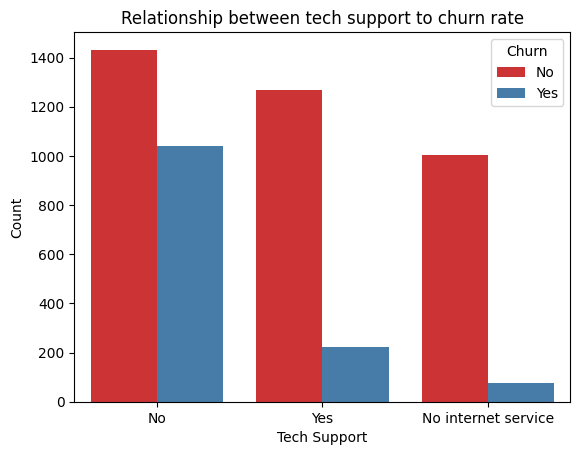

In [ ]:
sns.countplot(x='TechSupport', hue='Churn', data=full_data, palette='Set1')
plt.title('Relationship between tech support to churn rate')
plt.xlabel('Tech Support')
plt.ylabel('Count')
plt.show()

Customers that experience tech support were less likely to churn as compared to those that didn't experience tech support

9. **Are customers on different contract types more or less likely to churn?**

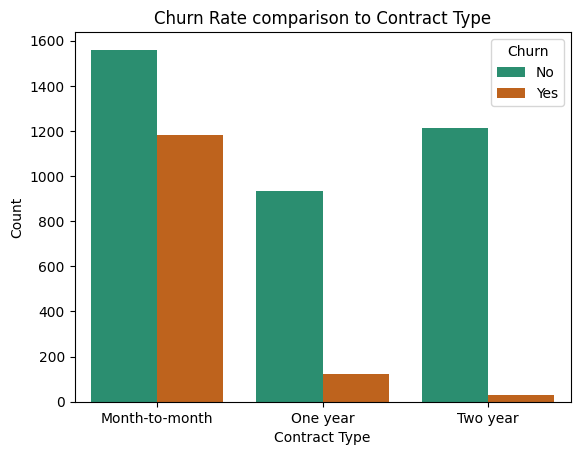

In [ ]:
sns.countplot(x='Contract', hue='Churn', data=full_data, palette='Dark2')
plt.title('Churn Rate comparison to Contract Type')
plt.xlabel('Contract Type')
plt.ylabel('Count')
plt.show()

The plot shows that majority of customers who churned had a month-to-month contract type. Contract types of one and two years had lower churn rates.

### FEATURE ENGINEERING

In [ ]:
telco_data['Churn'] = np.where(telco_data.Churn == 'Yes',1,0)

This transforms the values in the 'Churn' column of our DataFrame It's converting categorical values into binary numeric values for further analysis and modeling.
* If the value is 'Yes', it will be replaced with 1.
* If the value is not 'Yes' (i.e., it's NO), it will be replaced with 0.

In [ ]:
##creating our features and label

X= telco_data.drop("Churn", axis=1)
y= telco_data.Churn

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42, stratify=y)

We split the dataset into training and testing sets, along with their corresponding target variables.This help us evaluate the performance of our model on unseen data. The model will be trained on the training set and then tested on the testing set to assess its generalization ability.

In [ ]:
##getting our categorical attributes 
cat_attr= [i for i in telco_data.drop(["TotalCharges", "MonthlyCharges","tenure","Churn"], axis= 1)]


##getting our numerical attributes
num_attr= ["TotalCharges", "MonthlyCharges","tenure"]

We separate the columns of a DataFrame (telco_data) into two lists: one for categorical attributes and another for numerical attributes. we also drops the specified columns ("TotalCharges", "MonthlyCharges", "tenure", "Churn") from the DataFrame along the columns axis (axis=1). This results in a DataFrame with only the remaining columns, which are categorical attributes.

In [ ]:
# This pipeline will handle the standardize our numerical values

# we are using mean because from our previous analysis, there were no outliers

num_pipeline= Pipeline([("scaler", StandardScaler())])

cat_pipeline= Pipeline([("one_hot", OneHotEncoder())])

We are setting up two pipelines: one for standardizing numerical values and another for one-hot encoding categorical values.

In [ ]:
##we are combining our numeric and categorical pipelines with a Columntransformer

col_pipe= ColumnTransformer([("num_pipe", num_pipeline, num_attr),("cat_pipe", cat_pipeline, cat_attr)])
col_pipe

ColumnTransformer(transformers=[('num_pipe',
                                 Pipeline(steps=[('scaler', StandardScaler())]),
                                 ['TotalCharges', 'MonthlyCharges', 'tenure']),
                                ('cat_pipe',
                                 Pipeline(steps=[('one_hot', OneHotEncoder())]),
                                 ['gender', 'SeniorCitizen', 'Partner',
                                  'Dependents', 'PhoneService', 'MultipleLines',
                                  'InternetService', 'OnlineSecurity',
                                  'OnlineBackup', 'DeviceProtection',
                                  'TechSupport', 'StreamingTV',
                                  'StreamingMovies', 'Contract',
                                  'PaperlessBilling', 'PaymentMethod'])])

## Creating a pipeline for each Classifier (ML Algorithm)

#### DecisionTree CLassifier

In [ ]:
DTP= Pipeline([("coltrans", col_pipe), 
              ("model", DecisionTreeClassifier(random_state= 100))
              ])

This pipeline encapsulates the entire machine learning workflow, including preprocessing and modeling, in a single object. It helps ensure consistent preprocessing when making predictions and simplifies the process of building and evaluating our models.

In [ ]:
DTP.fit(X_train, y_train)

Pipeline(steps=[('coltrans',
                 ColumnTransformer(transformers=[('num_pipe',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['TotalCharges',
                                                   'MonthlyCharges',
                                                   'tenure']),
                                                 ('cat_pipe',
                                                  Pipeline(steps=[('one_hot',
                                                                   OneHotEncoder())]),
                                                  ['gender', 'SeniorCitizen',
                                                   'Partner', 'Dependents',
                                                   'PhoneService',
                                                   'MultipleLines',
                                                   'InternetService',
                                                   'OnlineSecurity',
                                                   'OnlineBackup',
                                                   'DeviceProtection',
                                                   'TechSupport', 'StreamingTV',
                                                   'StreamingMovies',
                                                   'Contract',
                                                   'PaperlessBilling',
                                                   'PaymentMethod'])])),
                ('model', DecisionTreeClassifier(random_state=100))])

In [ ]:
result_1 = DTP.predict(X_test)

This Ensure that X_test is properly preprocessed using the same pipeline (DTP) that we fitted to the training data (X_train) to ensure consistent preprocessing transformations is applied.
The resulting predictions (result_1) will be used for evaluation and analysis to assess the performance of our model.

In [ ]:
print(classification_report(y_test,result_1))

              precision    recall  f1-score   support

           0       0.82      0.79      0.81       742
           1       0.48      0.52      0.50       267

    accuracy                           0.72      1009
   macro avg       0.65      0.66      0.65      1009
weighted avg       0.73      0.72      0.73      1009



#### RandomForestClassifier

In [ ]:
RFP= Pipeline([("coltrans", col_pipe), 
              ("feature_selection", SelectKBest(score_func=f_classif, k=10)),
              ("model", RandomForestClassifier(n_estimators= 50, random_state= 100))
              ])

This pipeline encapsulates the entire machine learning workflow, including preprocessing, feature selection, and modeling, in a single object. It helps ensure consistent preprocessing and feature selection when making predictions and simplifies the process of building and evaluating our models.

In [ ]:
RFP.fit(X_train, y_train)

Pipeline(steps=[('coltrans',
                 ColumnTransformer(transformers=[('num_pipe',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['TotalCharges',
                                                   'MonthlyCharges',
                                                   'tenure']),
                                                 ('cat_pipe',
                                                  Pipeline(steps=[('one_hot',
                                                                   OneHotEncoder())]),
                                                  ['gender', 'SeniorCitizen',
                                                   'Partner', 'Dependents',
                                                   'PhoneService',
                                                   'MultipleLines',
                                                   'InternetService',
                                                   'OnlineSecurity',
                                                   'OnlineBackup',
                                                   'DeviceProtection',
                                                   'TechSupport', 'StreamingTV',
                                                   'StreamingMovies',
                                                   'Contract',
                                                   'PaperlessBilling',
                                                   'PaymentMethod'])])),
                ('feature_selection', SelectKBest()),
                ('model',
                 RandomForestClassifier(n_estimators=50, random_state=100))])

This Ensure that X_train is properly preprocessed and contains the same features as the training data you used to create the pipeline (col_pipe).
After fitting the pipeline, the trained model is ready to make predictions using the predict() method.

In [ ]:
result_2 = RFP.predict(X_test)

In [ ]:
print(classification_report( y_test,result_2))

              precision    recall  f1-score   support

           0       0.84      0.82      0.83       742
           1       0.53      0.55      0.54       267

    accuracy                           0.75      1009
   macro avg       0.68      0.69      0.68      1009
weighted avg       0.75      0.75      0.75      1009



#### Logistic RegressionClassifier 

In [ ]:
LRP= Pipeline([("coltrans", col_pipe), 
              ("feature_selection", SelectKBest(score_func=f_classif, k=10)),
              ("model", LogisticRegression(random_state= 100))
              ])

In [ ]:
LRP.fit(X_train, y_train)

Pipeline(steps=[('coltrans',
                 ColumnTransformer(transformers=[('num_pipe',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['TotalCharges',
                                                   'MonthlyCharges',
                                                   'tenure']),
                                                 ('cat_pipe',
                                                  Pipeline(steps=[('one_hot',
                                                                   OneHotEncoder())]),
                                                  ['gender', 'SeniorCitizen',
                                                   'Partner', 'Dependents',
                                                   'PhoneService',
                                                   'MultipleLines',
                                                   'InternetService',
                                                   'OnlineSecurity',
                                                   'OnlineBackup',
                                                   'DeviceProtection',
                                                   'TechSupport', 'StreamingTV',
                                                   'StreamingMovies',
                                                   'Contract',
                                                   'PaperlessBilling',
                                                   'PaymentMethod'])])),
                ('feature_selection', SelectKBest()),
                ('model', LogisticRegression(random_state=100))])

In [ ]:
result_3 = LRP.predict(X_test)

In [ ]:
print(classification_report(y_test,result_3))

              precision    recall  f1-score   support

           0       0.84      0.88      0.86       742
           1       0.62      0.53      0.57       267

    accuracy                           0.79      1009
   macro avg       0.73      0.71      0.72      1009
weighted avg       0.78      0.79      0.78      1009



#### Support Vector Classifier (SVC)

In [ ]:
SVP= Pipeline([("coltrans", col_pipe),  
               ("feature_selection: ", SelectKBest(score_func=f_classif, k= 10)),
               ("model", SVC(random_state= 100))
              ])

In [ ]:
SVP.fit(X_train, y_train)

Pipeline(steps=[('coltrans',
                 ColumnTransformer(transformers=[('num_pipe',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['TotalCharges',
                                                   'MonthlyCharges',
                                                   'tenure']),
                                                 ('cat_pipe',
                                                  Pipeline(steps=[('one_hot',
                                                                   OneHotEncoder())]),
                                                  ['gender', 'SeniorCitizen',
                                                   'Partner', 'Dependents',
                                                   'PhoneService',
                                                   'MultipleLines',
                                                   'InternetService',
                                                   'OnlineSecurity',
                                                   'OnlineBackup',
                                                   'DeviceProtection',
                                                   'TechSupport', 'StreamingTV',
                                                   'StreamingMovies',
                                                   'Contract',
                                                   'PaperlessBilling',
                                                   'PaymentMethod'])])),
                ('feature_selection: ', SelectKBest()),
                ('model', SVC(random_state=100))])

After creating and configuring the pipeline, you use the fit() method to train the model on your training data.
The pipeline takes care of all the preprocessing, feature selection, and training steps in a sequential manner.
Note:

By Ensure that X_train is properly preprocessed and contains the same features as the training data you used to create the pipeline (col_pipe).
After fitting the pipeline, the trained model is ready to make predictions using the predict() method.

In [ ]:
result_4 = SVP.predict(X_test)

In [ ]:
print(classification_report(y_test, result_4))

              precision    recall  f1-score   support

           0       0.84      0.89      0.87       742
           1       0.64      0.52      0.57       267

    accuracy                           0.79      1009
   macro avg       0.74      0.71      0.72      1009
weighted avg       0.78      0.79      0.79      1009



In [ ]:
#### Results after base modeling:

base_result= {"DTP": result_1, "RFP":result_2, "LRP": result_3, "SVP":result_4}

for key, value in base_result.items():
    
    print(f"The performance of {key} is: \n\n", classification_report(y_test, value))

The performance of DTP is: 

               precision    recall  f1-score   support

           0       0.82      0.79      0.81       742
           1       0.48      0.52      0.50       267

    accuracy                           0.72      1009
   macro avg       0.65      0.66      0.65      1009
weighted avg       0.73      0.72      0.73      1009

The performance of RFP is: 

               precision    recall  f1-score   support

           0       0.84      0.82      0.83       742
           1       0.53      0.55      0.54       267

    accuracy                           0.75      1009
   macro avg       0.68      0.69      0.68      1009
weighted avg       0.75      0.75      0.75      1009

The performance of LRP is: 

               precision    recall  f1-score   support

           0       0.84      0.88      0.86       742
           1       0.62      0.53      0.57       267

    accuracy                           0.79      1009
   macro avg       0.73      0.71     

### Dealing with Imbalance

In this section, we are going to see how functions like:

Class_weight for models that we will be using class weight, i will be appending "_CW" to the name to signify class_weight

SMOTE for models that we will be using class weight, i will be appending "_SMO" to the name to signify SMOTE
affect a model's performance

## Using Class_Weight to Handle imbalance

In [ ]:
##initializing our class weight for each class

class_weights = compute_class_weight('balanced', classes=[0, 1], y=y_train)

We are calculating class weights for each class in a binary classification problem. Class weights are used to address class imbalance in the training data, where one class might have significantly more samples than the other. They help the model to give more accurate predictions for both classes by considering the underlying class distribution.

In [ ]:
##assigning our weight to the respective class 

weight= dict(zip([0, 1], class_weights))

 Here we are creating a dictionary that maps class labels to their corresponding class weights. This dictionary will be used to provide custom class weights to a machine learning model during training. This helps the model learn from the underrepresented class more effectively.

#### Decision Tree

In [ ]:
CW_DTP = Pipeline([
    ("coltrans", col_pipe),
    ("feature_selection", SelectKBest(score_func=f_classif, k=10)),
    ("model", DecisionTreeClassifier(random_state= 100,class_weight= weight))
])

The custom class weights (weight) are assigned to the Decision Tree classifier through the class_weight parameter, which allows the model to address class imbalance during training.

In [ ]:
CW_DTP.fit(X_train, y_train)

Pipeline(steps=[('coltrans',
                 ColumnTransformer(transformers=[('num_pipe',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['TotalCharges',
                                                   'MonthlyCharges',
                                                   'tenure']),
                                                 ('cat_pipe',
                                                  Pipeline(steps=[('one_hot',
                                                                   OneHotEncoder())]),
                                                  ['gender', 'SeniorCitizen',
                                                   'Partner', 'Dependents',
                                                   'PhoneService',
                                                   'MultipleLines',
                                                   'InternetService',
                                                   'OnlineSecurity',
                                                   'OnlineBackup',
                                                   'DeviceProtection',
                                                   'TechSupport', 'StreamingTV',
                                                   'StreamingMovies',
                                                   'Contract',
                                                   'PaperlessBilling',
                                                   'PaymentMethod'])])),
                ('feature_selection', SelectKBest()),
                ('model',
                 DecisionTreeClassifier(class_weight={0: 0.6803306342780027,
                                                      1: 1.8863423760523854},
                                        random_state=100))])

In [ ]:
result_1_1 = CW_DTP.predict(X_test)

Here we are using the pipeline CW_DTP to make predictions on the testing data (X_test). 

In [ ]:
print(classification_report(y_test, result_1_1))

              precision    recall  f1-score   support

           0       0.87      0.75      0.81       742
           1       0.50      0.70      0.58       267

    accuracy                           0.74      1009
   macro avg       0.69      0.72      0.69      1009
weighted avg       0.77      0.74      0.75      1009



From the above output we can see that:

* Precision: For class 0, the precision is 0.87, which means that when the model predicts class 0, it is correct around 87% of the time. For class 1, the precision is 0.50, indicating that when the model predicts class 1, it is correct around 50% of the time.

* Recall: For class 0, the recall is 0.75, which means that out of all the actual instances of class 0 in the dataset, the model correctly identified 75% of them. For class 1, the recall is 0.70, indicating that the model correctly identified 70% of the actual instances of class 1.

* F1-Score: The F1-score is a balance between precision and recall. For class 0, the F1-score is 0.81, and for class 1, it is 0.58. The F1-score takes into account both false positives and false negatives, providing a balanced measure of a model's performance.

* Accuracy: The overall accuracy of the model is 0.74 or 74%. This means that the model correctly classified 74% of all instances in the testing data.

* Macro Average: The macro average of precision, recall, and F1-score is calculated by taking the average of these metrics across both classes. The macro average precision is 0.69, recall is 0.72, and F1-score is 0.69.

* Weighted Average: The weighted average takes into account the number of instances in each class. It gives more weight to the class with more instances. The weighted average precision is 0.77, recall is 0.74, and F1-score is 0.75.

#### Interpretation:

* The model has better precision for class 0 than for class 1, which means it's more accurate in predicting class 0.
* The recall for class 1 is higher than for class 0, indicating that the model is better at identifying class 1 instances.
* The F1-score provides a balanced measure considering both precision and recall. It's a good metric to assess the overall performance of the model.
* The accuracy is decent at 74%, but it's essential to consider precision, recall, and F1-score, especially in cases of class imbalance.
* The macro and weighted averages give a summarized view of the model's performance across classes, with weighted averages considering class distribution.

#### Conclusion:

The analysis of the classification report suggests that the model might be better at identifying instances of class 1, but it needs further evaluation, optimization, or potential handling of class imbalance to improve overall performance.

#### Random Forest Class Weight

In [ ]:
CW_RFC= Pipeline([("coltrans", col_pipe), 
                ("feature_selection", SelectKBest(score_func=f_classif, k=10)),
               ("model",RandomForestClassifier(random_state= 100, n_estimators= 50, class_weight=weight))
              ])

In [ ]:
CW_RFC.fit(X_train, y_train)

Pipeline(steps=[('coltrans',
                 ColumnTransformer(transformers=[('num_pipe',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['TotalCharges',
                                                   'MonthlyCharges',
                                                   'tenure']),
                                                 ('cat_pipe',
                                                  Pipeline(steps=[('one_hot',
                                                                   OneHotEncoder())]),
                                                  ['gender', 'SeniorCitizen',
                                                   'Partner', 'Dependents',
                                                   'PhoneService',
                                                   'MultipleLines',
                                                   'InternetService',
                                                   'OnlineSecurity',
                                                   'OnlineBackup',
                                                   'DeviceProtection',
                                                   'TechSupport', 'StreamingTV',
                                                   'StreamingMovies',
                                                   'Contract',
                                                   'PaperlessBilling',
                                                   'PaymentMethod'])])),
                ('feature_selection', SelectKBest()),
                ('model',
                 RandomForestClassifier(class_weight={0: 0.6803306342780027,
                                                      1: 1.8863423760523854},
                                        n_estimators=50, random_state=100))])

In [ ]:
result_2_2 = CW_RFC.predict(X_test)

In [ ]:
print(classification_report(y_test, result_2_2))

              precision    recall  f1-score   support

           0       0.86      0.78      0.82       742
           1       0.52      0.65      0.57       267

    accuracy                           0.75      1009
   macro avg       0.69      0.71      0.70      1009
weighted avg       0.77      0.75      0.75      1009



From the above output we can see that:

* Precision: For class 0, the precision is 0.86, indicating that when the model predicts class 0, it is correct around 86% of the time. For class 1, the precision is 0.52, indicating that when the model predicts class 1, it is correct around 52% of the time.

* Recall: For class 0, the recall is 0.78, indicating that out of all the actual instances of class 0 in the dataset, the model correctly identified 78% of them. For class 1, the recall is 0.65, indicating that the model correctly identified 65% of the actual instances of class 1.

* F1-Score: The F1-score is a balance between precision and recall. For class 0, the F1-score is 0.82, and for class 1, it is 0.57. The F1-score provides a balanced measure of a model's performance.

* Accuracy: The overall accuracy of the model is 0.75 or 75%. This means that the model correctly classified 75% of all instances in the testing data.

* Macro Average: The macro average of precision, recall, and F1-score is calculated by taking the average of these metrics across both classes. The macro average precision is 0.69, recall is 0.71, and F1-score is 0.70.

* Weighted Average: The weighted average takes into account the number of instances in each class. It gives more weight to the class with more instances. The weighted average precision is 0.77, recall is 0.75, and F1-score is 0.75.

#### Interpretation:

* Similar to the previous analysis, the model has better precision for class 0 than for class 1.
* The recall for class 1 is improved compared to the previous model, indicating that the model is better at identifying class 1 instances.
* The F1-score provides a balanced measure considering both precision and recall.
* The accuracy is decent at 75%, but as before, it's essential to consider precision, recall, and F1-score, especially in cases of class imbalance.
* The macro and weighted averages give a summarized view of the model's performance across classes, with weighted averages considering class distribution.

#### Conclusion:

The analysis of the classification report suggests that the model's performance has improved compared to the previous model in terms of recall for class 1. However, further evaluation, optimization, or handling of class imbalance may still be necessary to achieve even better performance.

#### Logistic RegressionClassifier 

In [ ]:
CW_LRP= Pipeline([("coltrans", col_pipe),  
            ("feature_selection", SelectKBest(score_func=f_classif, k=10)),
            ("model", LogisticRegression(random_state=100,class_weight=weight))
            ])

In [ ]:
CW_LRP.fit(X_train, y_train)

Pipeline(steps=[('coltrans',
                 ColumnTransformer(transformers=[('num_pipe',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['TotalCharges',
                                                   'MonthlyCharges',
                                                   'tenure']),
                                                 ('cat_pipe',
                                                  Pipeline(steps=[('one_hot',
                                                                   OneHotEncoder())]),
                                                  ['gender', 'SeniorCitizen',
                                                   'Partner', 'Dependents',
                                                   'PhoneService',
                                                   'MultipleLines',
                                                   'InternetService',
                                                   'OnlineSecurity',
                                                   'OnlineBackup',
                                                   'DeviceProtection',
                                                   'TechSupport', 'StreamingTV',
                                                   'StreamingMovies',
                                                   'Contract',
                                                   'PaperlessBilling',
                                                   'PaymentMethod'])])),
                ('feature_selection', SelectKBest()),
                ('model',
                 LogisticRegression(class_weight={0: 0.6803306342780027,
                                                  1: 1.8863423760523854},
                                    random_state=100))])

In [ ]:
result_3_3 = CW_LRP.predict(X_test)

In [ ]:
print(classification_report(y_test, result_3_3))

              precision    recall  f1-score   support

           0       0.91      0.71      0.80       742
           1       0.50      0.79      0.61       267

    accuracy                           0.73      1009
   macro avg       0.70      0.75      0.71      1009
weighted avg       0.80      0.73      0.75      1009



From the above output we can see that:

* Precision: For class 0, the precision is 0.91, indicating that when the model predicts class 0, it is correct around 91% of the time. For class 1, the precision is 0.50, indicating that when the model predicts class 1, it is correct around 50% of the time.

* Recall: For class 0, the recall is 0.71, indicating that out of all the actual instances of class 0 in the dataset, the model correctly identified 71% of them. For class 1, the recall is 0.79, indicating that the model correctly identified 79% of the actual instances of class 1.

* F1-Score: The F1-score is a balance between precision and recall. For class 0, the F1-score is 0.80, and for class 1, it is 0.61. The F1-score provides a balanced measure of a model's performance.

* Accuracy: The overall accuracy of the model is 0.73 or 73%. This means that the model correctly classified 73% of all instances in the testing data.

* Macro Average: The macro average of precision, recall, and F1-score is calculated by taking the average of these metrics across both classes. The macro average precision is 0.70, recall is 0.75, and F1-score is 0.71.

* Weighted Average: The weighted average takes into account the number of instances in each class. It gives more weight to the class with more instances. The weighted average precision is 0.80, recall is 0.73, and F1-score is 0.75.

#### Interpretation:

* The precision for class 0 is high, indicating that the model is quite accurate when predicting class 0, but the precision for class 1 is lower.
* The recall for class 1 is higher, indicating that the model is better at identifying class 1 instances.
* The F1-score provides a balanced measure considering both precision and recall.
* The accuracy is decent at 73%, but it's essential to consider precision, recall, and F1-score, especially in cases of class imbalance.
* The macro and weighted averages give a summarized view of the model's performance across classes, with weighted averages considering class distribution.

#### Conclusion:

The analysis of the classification report suggests that the model has improved recall for class 1 compared to the previous models. However, there's still room for improvement, and further evaluation or optimization may be needed to achieve better overall performance.






#### Support Vector Classifier (SVC)

In [ ]:
CW_SVM= Pipeline([("coltrans", col_pipe), 
                ("feature_selection", SelectKBest(score_func=f_classif, k=10)),
               ("model", SVC( random_state= 100, class_weight=weight))
              ])

In [ ]:
CW_SVM.fit(X_train, y_train)

Pipeline(steps=[('coltrans',
                 ColumnTransformer(transformers=[('num_pipe',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['TotalCharges',
                                                   'MonthlyCharges',
                                                   'tenure']),
                                                 ('cat_pipe',
                                                  Pipeline(steps=[('one_hot',
                                                                   OneHotEncoder())]),
                                                  ['gender', 'SeniorCitizen',
                                                   'Partner', 'Dependents',
                                                   'PhoneService',
                                                   'MultipleLines',
                                                   'InternetService',
                                                   'OnlineSecurity',
                                                   'OnlineBackup',
                                                   'DeviceProtection',
                                                   'TechSupport', 'StreamingTV',
                                                   'StreamingMovies',
                                                   'Contract',
                                                   'PaperlessBilling',
                                                   'PaymentMethod'])])),
                ('feature_selection', SelectKBest()),
                ('model',
                 SVC(class_weight={0: 0.6803306342780027,
                                   1: 1.8863423760523854},
                     random_state=100))])

In [ ]:
result_4_4 = CW_SVM.predict(X_test)

In [ ]:
print(classification_report(y_test, result_4_4))

              precision    recall  f1-score   support

           0       0.89      0.74      0.81       742
           1       0.51      0.75      0.61       267

    accuracy                           0.74      1009
   macro avg       0.70      0.74      0.71      1009
weighted avg       0.79      0.74      0.75      1009



 From the above output we can see that:
 
* Precision: For class `0`, the precision is 0.89, indicating that when the model predicts class `0`, it is correct around 89% of the time. For class `1`, the precision is 0.51, indicating that when the model predicts class `1`, it is correct around 51% of the time.

* Recall: For class `0`, the recall is 0.74, indicating that out of all the actual instances of class `0` in the dataset, the model correctly identified 74% of them. For class `1`, the recall is 0.75, indicating that the model correctly identified 75% of the actual instances of class `1`.

* F1-Score: The F1-score is a balance between precision and recall. For class `0`, the F1-score is 0.81, and for class `1`, it is 0.61. The F1-score provides a balanced measure of a model's performance.


* Accuracy: The overall accuracy of the model is 0.74 or 74%. This means that the model correctly classified 74% of all instances in the testing data.

* Macro Average: The macro average of precision, recall, and F1-score is calculated by taking the average of these metrics across both classes. The macro average precision is 0.70, recall is 0.74, and F1-score is 0.71.

* Weighted Average: The weighted average takes into account the number of instances in each class. It gives more weight to the class with more instances. The weighted average precision is 0.79, recall is 0.74, and F1-score is 0.75.


**Interpretation:**

* The precision for class `0` is high, indicating that the model is quite accurate when predicting class `0`, but the precision for class `1` is lower.
* The recall for both classes is balanced, with values of 0.74 and 0.75, indicating that the model is able to identify instances of both classes reasonably well.
* The F1-score provides a balanced measure considering both precision and recall.
* The accuracy is decent at 74%, but it's essential to consider precision, recall, and F1-score, especially in cases of class imbalance.
* The macro and weighted averages give a summarized view of the model's performance across classes, with weighted averages considering class distribution.

**Conclusion:**

The analysis of the classification report suggests that the model has improved recall for both classes compared to some of the previous models. However, there's still room for optimization and further evaluation to achieve better overall performance.

## Using SMOTE to Handle imbalance

**DECISION TreeClassifier**

In [ ]:
DTP_SMO = Pipeline([("coltrans", col_pipe), 
               ("feature_selection", SelectKBest(score_func=f_classif, k=10)),# Perform feature selection
               ("smote", SMOTE(random_state=100)),  # Apply SMOTE for oversampling
               ("model", DecisionTreeClassifier(random_state= 100))  
              ])

In [ ]:
DTP_SMO.fit(X_train, y_train)

Pipeline(steps=[('coltrans',
                 ColumnTransformer(transformers=[('num_pipe',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['TotalCharges',
                                                   'MonthlyCharges',
                                                   'tenure']),
                                                 ('cat_pipe',
                                                  Pipeline(steps=[('one_hot',
                                                                   OneHotEncoder())]),
                                                  ['gender', 'SeniorCitizen',
                                                   'Partner', 'Dependents',
                                                   'PhoneService',
                                                   'MultipleLines',
                                                   'InternetService',
                                                   'OnlineSecurity',
                                                   'OnlineBackup',
                                                   'DeviceProtection',
                                                   'TechSupport', 'StreamingTV',
                                                   'StreamingMovies',
                                                   'Contract',
                                                   'PaperlessBilling',
                                                   'PaymentMethod'])])),
                ('feature_selection', SelectKBest()),
                ('smote', SMOTE(random_state=100)),
                ('model', DecisionTreeClassifier(random_state=100))])

In [ ]:
result_1_1_1 = DTP_SMO.predict(X_test)

In [ ]:
print(classification_report(y_test, result_1_1_1))

              precision    recall  f1-score   support

           0       0.84      0.77      0.80       742
           1       0.48      0.58      0.53       267

    accuracy                           0.72      1009
   macro avg       0.66      0.68      0.66      1009
weighted avg       0.74      0.72      0.73      1009



From the above output we can see that:

- Precision: For class `0`, the precision is 0.84, indicating that when the model predicts class `0`, it is correct around 84% of the time. For class `1`, the precision is 0.48, indicating that when the model predicts class `1`, it is correct around 48% of the time.

- Recall: For class `0`, the recall is 0.77, indicating that out of all the actual instances of class `0` in the dataset, the model correctly identified 77% of them. For class `1`, the recall is 0.58, indicating that the model correctly identified 58% of the actual instances of class `1`.

- F1-Score: The F1-score is a balance between precision and recall. For class `0`, the F1-score is 0.80, and for class `1`, it is 0.53. The F1-score provides a balanced measure of a model's performance.

- Accuracy: The overall accuracy of the model is 0.72 or 72%. This means that the model correctly classified 72% of all instances in the testing data.

- Macro Average: The macro average of precision, recall, and F1-score is calculated by taking the average of these metrics across both classes. The macro average precision is 0.66, recall is 0.68, and F1-score is 0.66.

- Weighted Average: The weighted average takes into account the number of instances in each class. It gives more weight to the class with more instances. The weighted average precision is 0.74, recall is 0.72, and F1-score is 0.73.

**Interpretation:**
- The precision for class `0` is relatively high, indicating that the model is reasonably accurate when predicting class `0`. The precision for class `1` is lower.
- The recall for class `0` is also reasonably high, but the recall for class `1` is moderate.
- The F1-score provides a balanced measure considering both precision and recall.
- The accuracy is 72%, but it's important to consider precision, recall, and F1-score for a comprehensive understanding of model performance.
- The macro and weighted averages give a summarized view of the model's performance across classes, with weighted averages considering class distribution.

**Conclusion:**
- The analysis of the classification report suggests that the model's performance is moderate, with relatively good accuracy for class `0` but room for improvement in terms of precision and recall for class `1`. Further optimization or different techniques might be considered to improve overall performance.

**RANDOM FORREST**

In [ ]:
RF_SMO = Pipeline([("coltrans", col_pipe), 
               ("feature_selection", SelectKBest(score_func=f_classif, k=10)),# Perform feature selection
               ("smote", SMOTE(random_state=100)),  # Apply SMOTE for oversampling
               ("model",RandomForestClassifier(random_state= 100, n_estimators= 50))  
              ])

In [ ]:
RF_SMO.fit(X_train, y_train)

Pipeline(steps=[('coltrans',
                 ColumnTransformer(transformers=[('num_pipe',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['TotalCharges',
                                                   'MonthlyCharges',
                                                   'tenure']),
                                                 ('cat_pipe',
                                                  Pipeline(steps=[('one_hot',
                                                                   OneHotEncoder())]),
                                                  ['gender', 'SeniorCitizen',
                                                   'Partner', 'Dependents',
                                                   'PhoneService',
                                                   'MultipleLines',
                                                   'InternetService',
                                                   'OnlineSecurity',
                                                   'OnlineBackup',
                                                   'DeviceProtection',
                                                   'TechSupport', 'StreamingTV',
                                                   'StreamingMovies',
                                                   'Contract',
                                                   'PaperlessBilling',
                                                   'PaymentMethod'])])),
                ('feature_selection', SelectKBest()),
                ('smote', SMOTE(random_state=100)),
                ('model',
                 RandomForestClassifier(n_estimators=50, random_state=100))])

In [ ]:
result_2_2_2 = RF_SMO.predict(X_test)

In [ ]:
print(classification_report(y_test, result_2_2_2))

              precision    recall  f1-score   support

           0       0.87      0.77      0.81       742
           1       0.51      0.67      0.58       267

    accuracy                           0.74      1009
   macro avg       0.69      0.72      0.70      1009
weighted avg       0.77      0.74      0.75      1009



From the above output we can see that:

- Precision: For class `0`, the precision is 0.87, indicating that when the model predicts class `0`, it is correct around 87% of the time. For class `1`, the precision is 0.51, indicating that when the model predicts class `1`, it is correct around 51% of the time.

- Recall: For class `0`, the recall is 0.77, indicating that out of all the actual instances of class `0` in the dataset, the model correctly identified 77% of them. For class `1`, the recall is 0.67, indicating that the model correctly identified 67% of the actual instances of class `1`.

- F1-Score: The F1-score is a balance between precision and recall. For class `0`, the F1-score is 0.81, and for class `1`, it is 0.58. The F1-score provides a balanced measure of a model's performance.

- Accuracy: The overall accuracy of the model is 0.74 or 74%. This means that the model correctly classified 74% of all instances in the testing data.

- Macro Average: The macro average of precision, recall, and F1-score is calculated by taking the average of these metrics across both classes. The macro average precision is 0.69, recall is 0.72, and F1-score is 0.70.

- Weighted Average: The weighted average takes into account the number of instances in each class. It gives more weight to the class with more instances. The weighted average precision is 0.77, recall is 0.74, and F1-score is 0.75.

**Interpretation:**
- The precision for class `0` is relatively high, indicating that the model is quite accurate when predicting class `0`, but the precision for class `1` is lower.
- The recall for both classes is reasonable, with values of 0.77 and 0.67, indicating that the model is able to identify instances of both classes with moderate accuracy.
- The F1-score provides a balanced measure considering both precision and recall.
- The accuracy is decent at 74%, but it's important to consider precision, recall, and F1-score for a comprehensive understanding of model performance.
- The macro and weighted averages give a summarized view of the model's performance across classes, with weighted averages considering class distribution.

**Conclusion:**
- The analysis of the classification report suggests that the model's performance is moderate, with relatively good accuracy for class `0` but room for improvement in terms of precision and recall for class `1`. Further optimization or different techniques might be considered to improve overall performance.

**Logistic RegressionClassifier**

In [ ]:
LGR_SMO = Pipeline([("coltrans", col_pipe), 
               ("feature_selection", SelectKBest(score_func=f_classif, k=10)),# Perform feature selection
               ("smote", SMOTE(random_state=100)),  # Apply SMOTE for oversampling
               ("model", LogisticRegression(random_state= 100))  
              ])

In [ ]:
LGR_SMO.fit(X_train, y_train)

Pipeline(steps=[('coltrans',
                 ColumnTransformer(transformers=[('num_pipe',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['TotalCharges',
                                                   'MonthlyCharges',
                                                   'tenure']),
                                                 ('cat_pipe',
                                                  Pipeline(steps=[('one_hot',
                                                                   OneHotEncoder())]),
                                                  ['gender', 'SeniorCitizen',
                                                   'Partner', 'Dependents',
                                                   'PhoneService',
                                                   'MultipleLines',
                                                   'InternetService',
                                                   'OnlineSecurity',
                                                   'OnlineBackup',
                                                   'DeviceProtection',
                                                   'TechSupport', 'StreamingTV',
                                                   'StreamingMovies',
                                                   'Contract',
                                                   'PaperlessBilling',
                                                   'PaymentMethod'])])),
                ('feature_selection', SelectKBest()),
                ('smote', SMOTE(random_state=100)),
                ('model', LogisticRegression(random_state=100))])

In [ ]:
result_3_3_3 = LGR_SMO.predict(X_test)

In [ ]:
print(classification_report(y_test, result_3_3_3))

              precision    recall  f1-score   support

           0       0.90      0.72      0.80       742
           1       0.50      0.79      0.61       267

    accuracy                           0.73      1009
   macro avg       0.70      0.75      0.70      1009
weighted avg       0.80      0.73      0.75      1009



From the above output we can see that:

- Precision: For class `0`, the precision is 0.90, indicating that when the model predicts class `0`, it is correct around 90% of the time. For class `1`, the precision is 0.50, indicating that when the model predicts class `1`, it is correct around 50% of the time.

- Recall: For class `0`, the recall is 0.72, indicating that out of all the actual instances of class `0` in the dataset, the model correctly identified 72% of them. For class `1`, the recall is 0.79, indicating that the model correctly identified 79% of the actual instances of class `1`.

- F1-Score: The F1-score is a balance between precision and recall. For class `0`, the F1-score is 0.80, and for class `1`, it is 0.61. The F1-score provides a balanced measure of a model's performance.

- Accuracy: The overall accuracy of the model is 0.73 or 73%. This means that the model correctly classified 73% of all instances in the testing data.

- Macro Average: The macro average of precision, recall, and F1-score is calculated by taking the average of these metrics across both classes. The macro average precision is 0.70, recall is 0.75, and F1-score is 0.70.

- Weighted Average: The weighted average takes into account the number of instances in each class. It gives more weight to the class with more instances. The weighted average precision is 0.80, recall is 0.73, and F1-score is 0.75.

**Interpretation:**
- The precision for class `0` is high, indicating that the model is quite accurate when predicting class `0`, but the precision for class `1` is lower.
- The recall for class `1` is higher, indicating that the model is better at identifying class `1` instances.
- The F1-score provides a balanced measure considering both precision and recall.
- The accuracy is decent at 73%, but it's important to consider precision, recall, and F1-score for a comprehensive understanding of model performance.
- The macro and weighted averages give a summarized view of the model's performance across classes, with weighted averages considering class distribution.

**Conclusion:**
- The analysis of the classification report suggests that the model's performance has improved recall for class `1`, similar to some of the previous models. However, there's still room for optimization and further evaluation to achieve better overall performance.

#### Support Vector Classifier (SVC)

In [ ]:
SVM_SMO = Pipeline([("coltrans", col_pipe), 
               ("feature_selection", SelectKBest(score_func=f_classif, k=10)),# Perform feature selection
               ("smote", SMOTE(random_state=100)),  # Apply SMOTE for oversampling
               ("model", SVC(random_state= 100))  
              ])

In [ ]:
SVM_SMO.fit(X_train, y_train)

Pipeline(steps=[('coltrans',
                 ColumnTransformer(transformers=[('num_pipe',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['TotalCharges',
                                                   'MonthlyCharges',
                                                   'tenure']),
                                                 ('cat_pipe',
                                                  Pipeline(steps=[('one_hot',
                                                                   OneHotEncoder())]),
                                                  ['gender', 'SeniorCitizen',
                                                   'Partner', 'Dependents',
                                                   'PhoneService',
                                                   'MultipleLines',
                                                   'InternetService',
                                                   'OnlineSecurity',
                                                   'OnlineBackup',
                                                   'DeviceProtection',
                                                   'TechSupport', 'StreamingTV',
                                                   'StreamingMovies',
                                                   'Contract',
                                                   'PaperlessBilling',
                                                   'PaymentMethod'])])),
                ('feature_selection', SelectKBest()),
                ('smote', SMOTE(random_state=100)),
                ('model', SVC(random_state=100))])

In [ ]:
result_4_4_4 = SVM_SMO.predict(X_test)

In [ ]:
print(classification_report(y_test, result_4_4_4))

# Evaluate the model
accuracy = accuracy_score(y_test, result_4_4_4)
print(f'Accuracy: {accuracy:.7f}')

              precision    recall  f1-score   support

           0       0.90      0.74      0.81       742
           1       0.52      0.76      0.62       267

    accuracy                           0.75      1009
   macro avg       0.71      0.75      0.71      1009
weighted avg       0.80      0.75      0.76      1009

Accuracy: 0.7482656


From the above output we can see that:

- Precision: For class `0`, the precision is 0.90, indicating that when the model predicts class `0`, it is correct around 90% of the time. For class `1`, the precision is 0.52, indicating that when the model predicts class `1`, it is correct around 52% of the time.

- Recall: For class `0`, the recall is 0.74, indicating that out of all the actual instances of class `0` in the dataset, the model correctly identified 74% of them. For class `1`, the recall is 0.76, indicating that the model correctly identified 76% of the actual instances of class `1`.

- F1-Score: The F1-score is a balance between precision and recall. For class `0`, the F1-score is 0.81, and for class `1`, it is 0.62. The F1-score provides a balanced measure of a model's performance.

- Accuracy: The overall accuracy of the model is 0.7482656 or approximately 74.83%. This means that the model correctly classified about 74.83% of all instances in the testing data.

- Macro Average: The macro average of precision, recall, and F1-score is calculated by taking the average of these metrics across both classes. The macro average precision is 0.71, recall is 0.75, and F1-score is 0.71.

- Weighted Average: The weighted average takes into account the number of instances in each class. It gives more weight to the class with more instances. The weighted average precision is 0.80, recall is 0.75, and F1-score is 0.76.

**Interpretation:**
- The precision for class `0` is high, indicating that the model is quite accurate when predicting class `0`, but the precision for class `1` is lower.
- The recall for class `1` is higher, indicating that the model is better at identifying class `1` instances.
- The F1-score provides a balanced measure considering both precision and recall.
- The accuracy is approximately 74.83%, but it's important to consider precision, recall, and F1-score for a comprehensive understanding of model performance.
- The macro and weighted averages give a summarized view of the model's performance across classes, with weighted averages considering class distribution.

**Conclusion:**
- The analysis of the classification report suggests that the model's performance has improved recall for class `1`, similar to some of the previous models. The accuracy is also decent, and the model is providing a balanced trade-off between precision and recall.

**Metrics we would use for assessments**

Accuracy score: This measures the overall accuracy of the model for both the training and testing datasets.

Precision-Recall Curve: This illustrates the diagnostic ability of the model by examining false positive rate (FPR) and false negative rate (FNR) at different thresholds of class predictions. This metric is suitable for datasets with imbalanced classes as it is not reliant on the number of true negatives.

F1 Score: This metric calculates the harmonic mean of precision and recall to determine the balance between both metrics.

**Comparing results of Class_weight vs SMOTE vs Baseline**

In [ ]:
imbalance_result= {"Decision Tree":result_1, "Decision Tree_SM":result_1_1, "Decision_Tree_CW":result_1_1_1, 
               
                   "Logistic Regression": result_2, "Logistic Regression_SM":result_2_2, "Logistic_Regression_CW": result_2_2_2, 
            
             "Random Forest": result_3, "Random Forest_SM": result_3_3, "Random_Forest_CW":result_3_3_3, 
                   
                   "SVM": result_4, "SVM_SM": result_4_4,"SVM_CW":result_4_4_4}

for key, value in imbalance_result.items():
    
    print(f"Classification Report for {key}, is: \n\n",(classification_report(y_test,value)))

Classification Report for Decision Tree, is: 

               precision    recall  f1-score   support

           0       0.82      0.79      0.81       742
           1       0.48      0.52      0.50       267

    accuracy                           0.72      1009
   macro avg       0.65      0.66      0.65      1009
weighted avg       0.73      0.72      0.73      1009

Classification Report for Decision Tree_SM, is: 

               precision    recall  f1-score   support

           0       0.87      0.75      0.81       742
           1       0.50      0.70      0.58       267

    accuracy                           0.74      1009
   macro avg       0.69      0.72      0.69      1009
weighted avg       0.77      0.74      0.75      1009

Classification Report for Decision_Tree_CW, is: 

               precision    recall  f1-score   support

           0       0.84      0.77      0.80       742
           1       0.48      0.58      0.53       267

    accuracy                    

Considering these metrics, it's important to balance precision and recall, especially in the context of customer churn analysis:

Best Precision: Random Forest has the highest precision (0.62) among the models, indicating fewer false positive predictions. However, precision alone might not be the only deciding factor.

Best Recall: SVM_SM has the highest recall (0.75), indicating that it captures a higher proportion of actual positive instances (churn cases).

Best F1-Score: Among the models, SVM_SM and SVM_CW have the highest F1-score (0.61), indicating a balance between precision and recall.

Best Accuracy: Random Forest has the highest accuracy (0.79), but accuracy alone might not provide a complete picture, especially in imbalanced datasets like customer churn.

Given the context of customer churn analysis, where correctly identifying churn instances is crucial for business decisions, a model with a good balance between precision and recall is desirable. Therefore, considering the F1-score and considering the trade-off between precision and recall, the SVM_SM or SVM_CW models might be more suitable choices. These models have the highest F1-score (0.61) and a relatively balanced recall and precision.

**HYPERPARAMETER TUNING - GridSearchCV**

In [ ]:
# Define the pipeline steps
CW_SVM = Pipeline([
    ("coltrans", col_pipe),  # Your column transformer, assumed to be defined elsewhere
    ("feature_selection", SelectKBest(score_func=f_classif, k=10)),  # Feature selection step
    ("model", SVC(random_state=100, class_weight=weight))  # SVM model with class weights
])

# Define the parameter grid for tuning
param_grid = {
    'feature_selection__k': [5, 10, 15],  # Number of features to select
    'model__C': [0.1, 1, 10],             # SVM regularization parameter
    'model__gamma': ['scale', 'auto'],    # Kernel coefficient for 'rbf' kernel
}

# Create the GridSearchCV object
grid_search = GridSearchCV(CW_SVM, param_grid, cv=5, scoring='f1')

# Fit the GridSearchCV object to the training data
grid_search.fit(X_train, y_train)

# Get the best parameters and best estimator from the grid search
best_params = grid_search.best_params_
best_estimator = grid_search.best_estimator_

# Make predictions on the test data using the best estimator
result_4_4_2 = best_estimator.predict(X_test)

# Print the classification report
print(classification_report(y_test, result_4_4_2))


              precision    recall  f1-score   support

           0       0.89      0.74      0.81       742
           1       0.51      0.75      0.61       267

    accuracy                           0.74      1009
   macro avg       0.70      0.74      0.71      1009
weighted avg       0.79      0.74      0.75      1009



From the above output we can see that:

- Precision: For class `0`, the precision is 0.89, indicating that when the model predicts class `0`, it is correct around 89% of the time. For class `1`, the precision is 0.51, indicating that when the model predicts class `1`, it is correct around 51% of the time.

- Recall: For class `0`, the recall is 0.74, indicating that out of all the actual instances of class `0` in the dataset, the model correctly identified 74% of them. For class `1`, the recall is 0.75, indicating that the model correctly identified 75% of the actual instances of class `1`.

- F1-Score: The F1-score is a balance between precision and recall. For class `0`, the F1-score is 0.81, and for class `1`, it is 0.61. The F1-score provides a balanced measure of a model's performance.

- Accuracy: The overall accuracy of the model is 0.74 or 74%. This means that the model correctly classified 74% of all instances in the testing data.

- Macro Average: The macro average of precision, recall, and F1-score is calculated by taking the average of these metrics across both classes. The macro average precision is 0.70, recall is 0.74, and F1-score is 0.71.

- Weighted Average: The weighted average takes into account the number of instances in each class. It gives more weight to the class with more instances. The weighted average precision is 0.79, recall is 0.74, and F1-score is 0.75.

**Interpretation:**
- The precision for class `0` is high, indicating that the model is quite accurate when predicting class `0`, but the precision for class `1` is lower.
- The recall for class `0` is decent, and the recall for class `1` is also reasonable.
- The F1-score provides a balanced measure considering both precision and recall.
- The accuracy is 74%, which is decent, but it's important to consider precision, recall, and F1-score for a comprehensive understanding of model performance.
- The macro and weighted averages give a summarized view of the model's performance across classes, with weighted averages considering class distribution.

**Hyperparameter Tuning (GridSearchCV):**
- GridSearchCV is used to search for the best combination of hyperparameters from the provided parameter grid.
- It performs cross-validation to evaluate different combinations of hyperparameters and selects the best performing one based on the provided scoring metric (in this case, 'f1').
- The best parameters and best estimator are obtained from the `best_params_` and `best_estimator_` attributes of the GridSearchCV object.
- The best estimator is then used to make predictions on the test data.

**Conclusion:**
- The analysis of the classification report suggests that the tuned model's performance is similar to the base model in terms of accuracy, precision, recall, and F1-score. 

In [ ]:
result_4_4_2

array([0, 0, 0, ..., 1, 1, 0])

In [ ]:
X_test.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
1947,Female,No,No,No,70,Yes,Yes,Fiber optic,No,Yes,Yes,Yes,No,No,One year,Yes,Bank transfer (automatic),90.25,6385.95
3102,Female,No,Yes,No,72,Yes,Yes,Fiber optic,Yes,No,Yes,Yes,Yes,Yes,Two year,Yes,Credit card (automatic),110.15,7881.20
3811,Male,No,Yes,No,61,Yes,Yes,DSL,No,Yes,Yes,No,Yes,Yes,Two year,No,Bank transfer (automatic),80.90,4932.50
3668,Female,Yes,Yes,No,39,Yes,Yes,Fiber optic,No,No,No,Yes,Yes,Yes,Month-to-month,Yes,Electronic check,101.25,3949.15
1570,Female,No,Yes,Yes,23,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Bank transfer (automatic),20.40,478.75


In [ ]:
# Create a DataFrame to hold the test data and predictions
test_data = pd.DataFrame(X_test, columns=X_test.columns)
test_data['Churn'] = result_4_4_2

# Print the first few rows of the combined DataFrame
test_data.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
1947,Female,No,No,No,70,Yes,Yes,Fiber optic,No,Yes,Yes,Yes,No,No,One year,Yes,Bank transfer (automatic),90.25,6385.95,0
3102,Female,No,Yes,No,72,Yes,Yes,Fiber optic,Yes,No,Yes,Yes,Yes,Yes,Two year,Yes,Credit card (automatic),110.15,7881.20,0
3811,Male,No,Yes,No,61,Yes,Yes,DSL,No,Yes,Yes,No,Yes,Yes,Two year,No,Bank transfer (automatic),80.90,4932.50,0
3668,Female,Yes,Yes,No,39,Yes,Yes,Fiber optic,No,No,No,Yes,Yes,Yes,Month-to-month,Yes,Electronic check,101.25,3949.15,1
1570,Female,No,Yes,Yes,23,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Bank transfer (automatic),20.40,478.75,0


We combined the original features of the test data with the predicted churn values made by the model. By creating the test_data DataFrame, helps us to easily observe and analyze how the model's predictions align with the actual test data. The printed output displays a table where each row represents an instance from the test data, and the columns show the individual features as well as the predicted churn values.
